# **Demonstration of Flight Dynamics Surrogate Model for High-Altitude Stall Upset**

**Python Libraries Needed**

In [82]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os

**User Input**

In [83]:
FName = "TCM_Data1.csv"
outDir = "Results_ML"
window_size = 20 # How many previous time steps will be used to predict the current time step
btch_sz = 32 # Batches for training
shuffle_buffer_size = 1000 # just to speed up the shuffling (optional)
trainingEpcohs = 2 #5000
gtm_dt = 0.02
InitialT = 0


**Reading TCM Data Preprocessing Scaling functions**

In [84]:
def scaling_Stand(x):
    meanX = np.mean(x)
    stdX = np.std(x)
    return (x-meanX)/stdX

def scalingbk_Stand(scaled_x, org_x):
    meanX = np.mean(org_x)
    stdX = np.std(org_x)
    return (scaled_x*stdX)+meanX

def toNumpy(dataFrame):
    numpyList = np.zeros(dataFrame.shape)
    for i in range(numpyList.shape[1]):
        numpyList[:,i] = dataFrame.iloc[:,i]
    return numpyList


In [85]:
def read_input(data_dir):
    gtm_trj = pd.read_csv(data_dir,sep=',')
    gtm_trj_orignal = toNumpy(gtm_trj)
    #print(gtm_trj_orignal)
    scale_cols = ['u', 'v', 'w', 'p', 'q', 'r', 'p_dot', 'q_dot', 'r_dot','lat','lon','alt']
    control_cols = ['aileron','elevator','rudder']
    gtm_trj_ToBe_scaled = gtm_trj[scale_cols]

    gtm_trj_scaled_list = np.zeros(gtm_trj_ToBe_scaled.shape)
    for i in range(gtm_trj_scaled_list.shape[1]):
        gtm_trj_scaled_list[:,i] = scaling_Stand(gtm_trj_ToBe_scaled.iloc[:,i])

    gtm_control = gtm_trj[control_cols]
    gtm_control_list = toNumpy(gtm_control)

    gtm_data_list = np.concatenate([gtm_trj_scaled_list,gtm_control_list],axis=1)
    print("data size",gtm_data_list.shape)

    return gtm_data_list,gtm_trj_ToBe_scaled,gtm_trj_orignal

def getTime(TotalSteps,stepSize):
    return (TotalSteps*stepSize) - stepSize


**Reading TCM input data, scaling the data using standard normal distribution and split the data into training and validation datasets**



In [86]:
scaled_Data,gtm_trj_ToBe_scaled,orignalData = read_input(FName)
TotalTime = getTime(scaled_Data.shape[0],gtm_dt)
print(TotalTime)

data size (4548, 15)
90.94000000000001


In [87]:
def train_split(gtm_data_list,split_ratio=0.8):
    split_time = round(split_ratio*gtm_data_list.shape[0])
    x_train = gtm_data_list[:split_time]
    x_valid = gtm_data_list[split_time:]
    print(x_train.shape)
    print(x_valid.shape)
    return x_train, x_valid


In [88]:
x_train, x_valid = train_split(scaled_Data,0.8)

(3638, 15)
(910, 15)


**Functions to define the number of initial steps (initial conditions)**

In [89]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer) # data shuffling
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def windowed_dataset_predict(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def dataSet_numpy(btch_sz,window_size,parmCtrl,dataset):
    dataSetX = np.zeros((btch_sz,window_size,parmCtrl))
    dataSetY = np.zeros((btch_sz,12))

    counter = 0
    for x, y in dataset:
        if counter ==0:
            dataSetX[0:btch_sz,:,:] = x.numpy()
            dataSetY[0:btch_sz,:] = y.numpy()[:,0:12]
        else:
            dataSetX = np.append(dataSetX,x.numpy(),axis=0)
            dataSetY = np.append(dataSetY,y.numpy()[:,0:12],axis=0)
        counter +=1

    print(dataSetX.shape)
    print(dataSetY.shape)

    return dataSetX, dataSetY
    

**Convert the training dataset into windowed dataset; where n previous steps (window size) are used to predict the current steps**

In [90]:
dataset = windowed_dataset(x_train, window_size, btch_sz, shuffle_buffer_size)
dataSetX, dataSetY = dataSet_numpy(btch_sz,window_size,x_train.shape[1],dataset)

(3618, 20, 15)
(3618, 12)


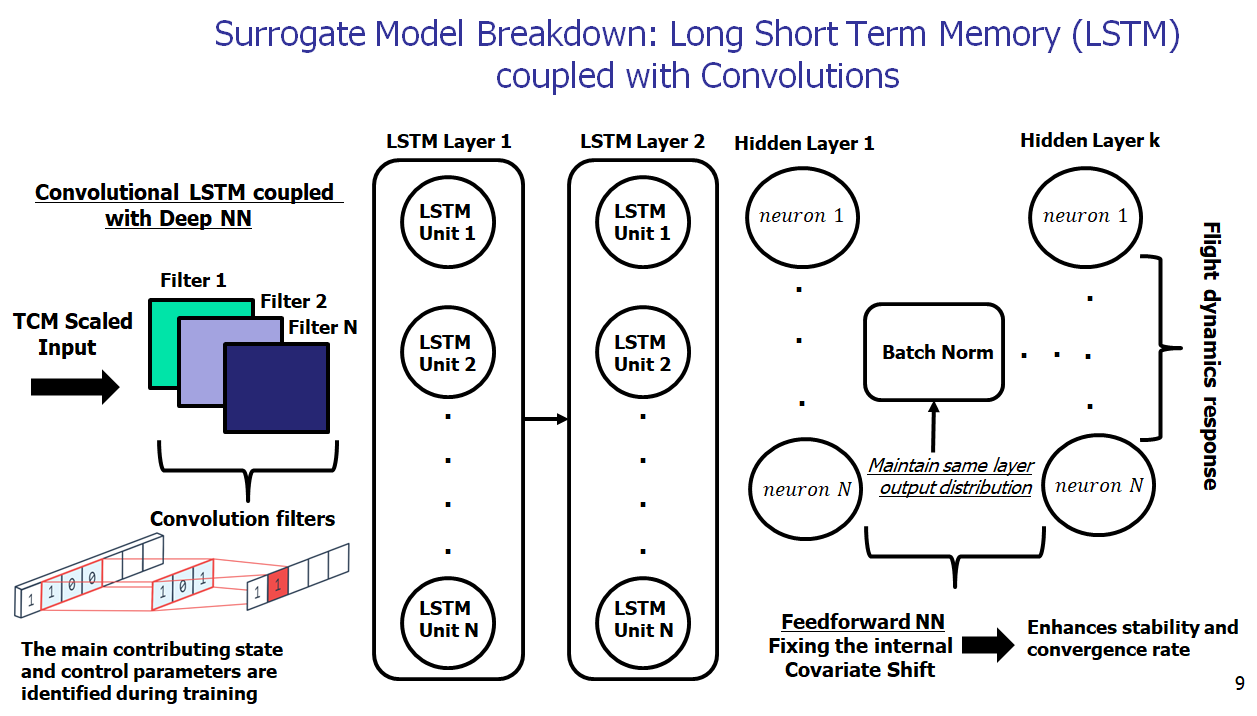

**Neural Nets Architectures**

In [91]:
def myLSTM(sysFlag):
    if sysFlag ==0:
        import tensorflow as tf
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.layers import Flatten
        from tensorflow.keras.layers import Reshape
        from tensorflow.keras.layers import Lambda
        from tensorflow.keras.layers import Bidirectional
        from tensorflow.keras.layers import LSTM
        from tensorflow.keras.layers import BatchNormalization
        from tensorflow.keras.layers import Conv1D
    elif sysFlag==1:
        import tensorflow as tf
        from keras.layers import Dense
        from keras.layers import Flatten
        from keras.layers import Reshape
        from keras.layers import Lambda
        from keras.layers import Bidirectional
        from keras.layers import LSTM
        from keras.layers import BatchNormalization
        from keras.layers import Conv1D

    model = tf.keras.models.Sequential()
    #model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(12))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    return model

def myLSTM_DNN(sysFlag):
    if sysFlag ==0:
        import tensorflow as tf
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.layers import Flatten
        from tensorflow.keras.layers import Reshape
        from tensorflow.keras.layers import Lambda
        from tensorflow.keras.layers import Bidirectional
        from tensorflow.keras.layers import LSTM
        from tensorflow.keras.layers import BatchNormalization
        from tensorflow.keras.layers import Conv1D
    elif sysFlag==1:
        import tensorflow as tf
        from keras.layers import Dense
        from keras.layers import Flatten
        from keras.layers import Reshape
        from keras.layers import Lambda
        from keras.layers import Bidirectional
        from keras.layers import LSTM
        from keras.layers import BatchNormalization
        from keras.layers import Conv1D

    model = tf.keras.models.Sequential()
    #model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32,return_sequences=True)))
    model.add(Dense(70, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(70, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(12))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    return model

def myLSTM_DNN_Conv(window_size,paramCrl,sysFlag):
    if sysFlag ==0:
        import tensorflow as tf
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.layers import Flatten
        from tensorflow.keras.layers import Reshape
        from tensorflow.keras.layers import Lambda
        from tensorflow.keras.layers import Bidirectional
        from tensorflow.keras.layers import LSTM
        from tensorflow.keras.layers import BatchNormalization
        from tensorflow.keras.layers import Conv1D
    elif sysFlag==1:
        import tensorflow as tf
        from keras.layers import Dense
        from keras.layers import Flatten
        from keras.layers import Reshape
        from keras.layers import Lambda
        from keras.layers import Bidirectional
        from keras.layers import LSTM
        from keras.layers import BatchNormalization
        from keras.layers import Conv1D
        
    model = tf.keras.models.Sequential()
    #model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
    model.add(Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=(window_size,paramCrl)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Bidirectional(LSTM(32,return_sequences=True)))
    model.add(Dense(70, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(70, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(12))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    return model


**Training the Surrogate Model**

In [92]:
model = myLSTM_DNN_Conv(window_size,x_train.shape[1],0)
history = model.fit(dataSetX,dataSetY,batch_size=btch_sz, epochs=trainingEpcohs,verbose=1)
history.model.save(r'surrogate.h5')

Epoch 1/2
114/114 [==============================] - 12s 36ms/step - loss: 2.5058
Epoch 2/2
114/114 [==============================] - 4s 35ms/step - loss: 2.2371


**Plotting the loss function**

In [93]:
def plotLoss(epochs,loss,outDir):
    if os.path.isdir(outDir):
        pass
    else:
        os.mkdir(outDir)
    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    ax = fig.add_subplot()
    ax.set_yscale("log")
    plt.xlabel('epochs')
    plt.ylabel('Training Loss')
    fig.tight_layout()
    plt.semilogy(epochs, loss, 'k',antialiased=True,linewidth=2.0)
    FileOut = "loss_trainingV0_Clstm.png"
    plt.savefig(os.path.join(outDir,FileOut),bbox_inches='tight')


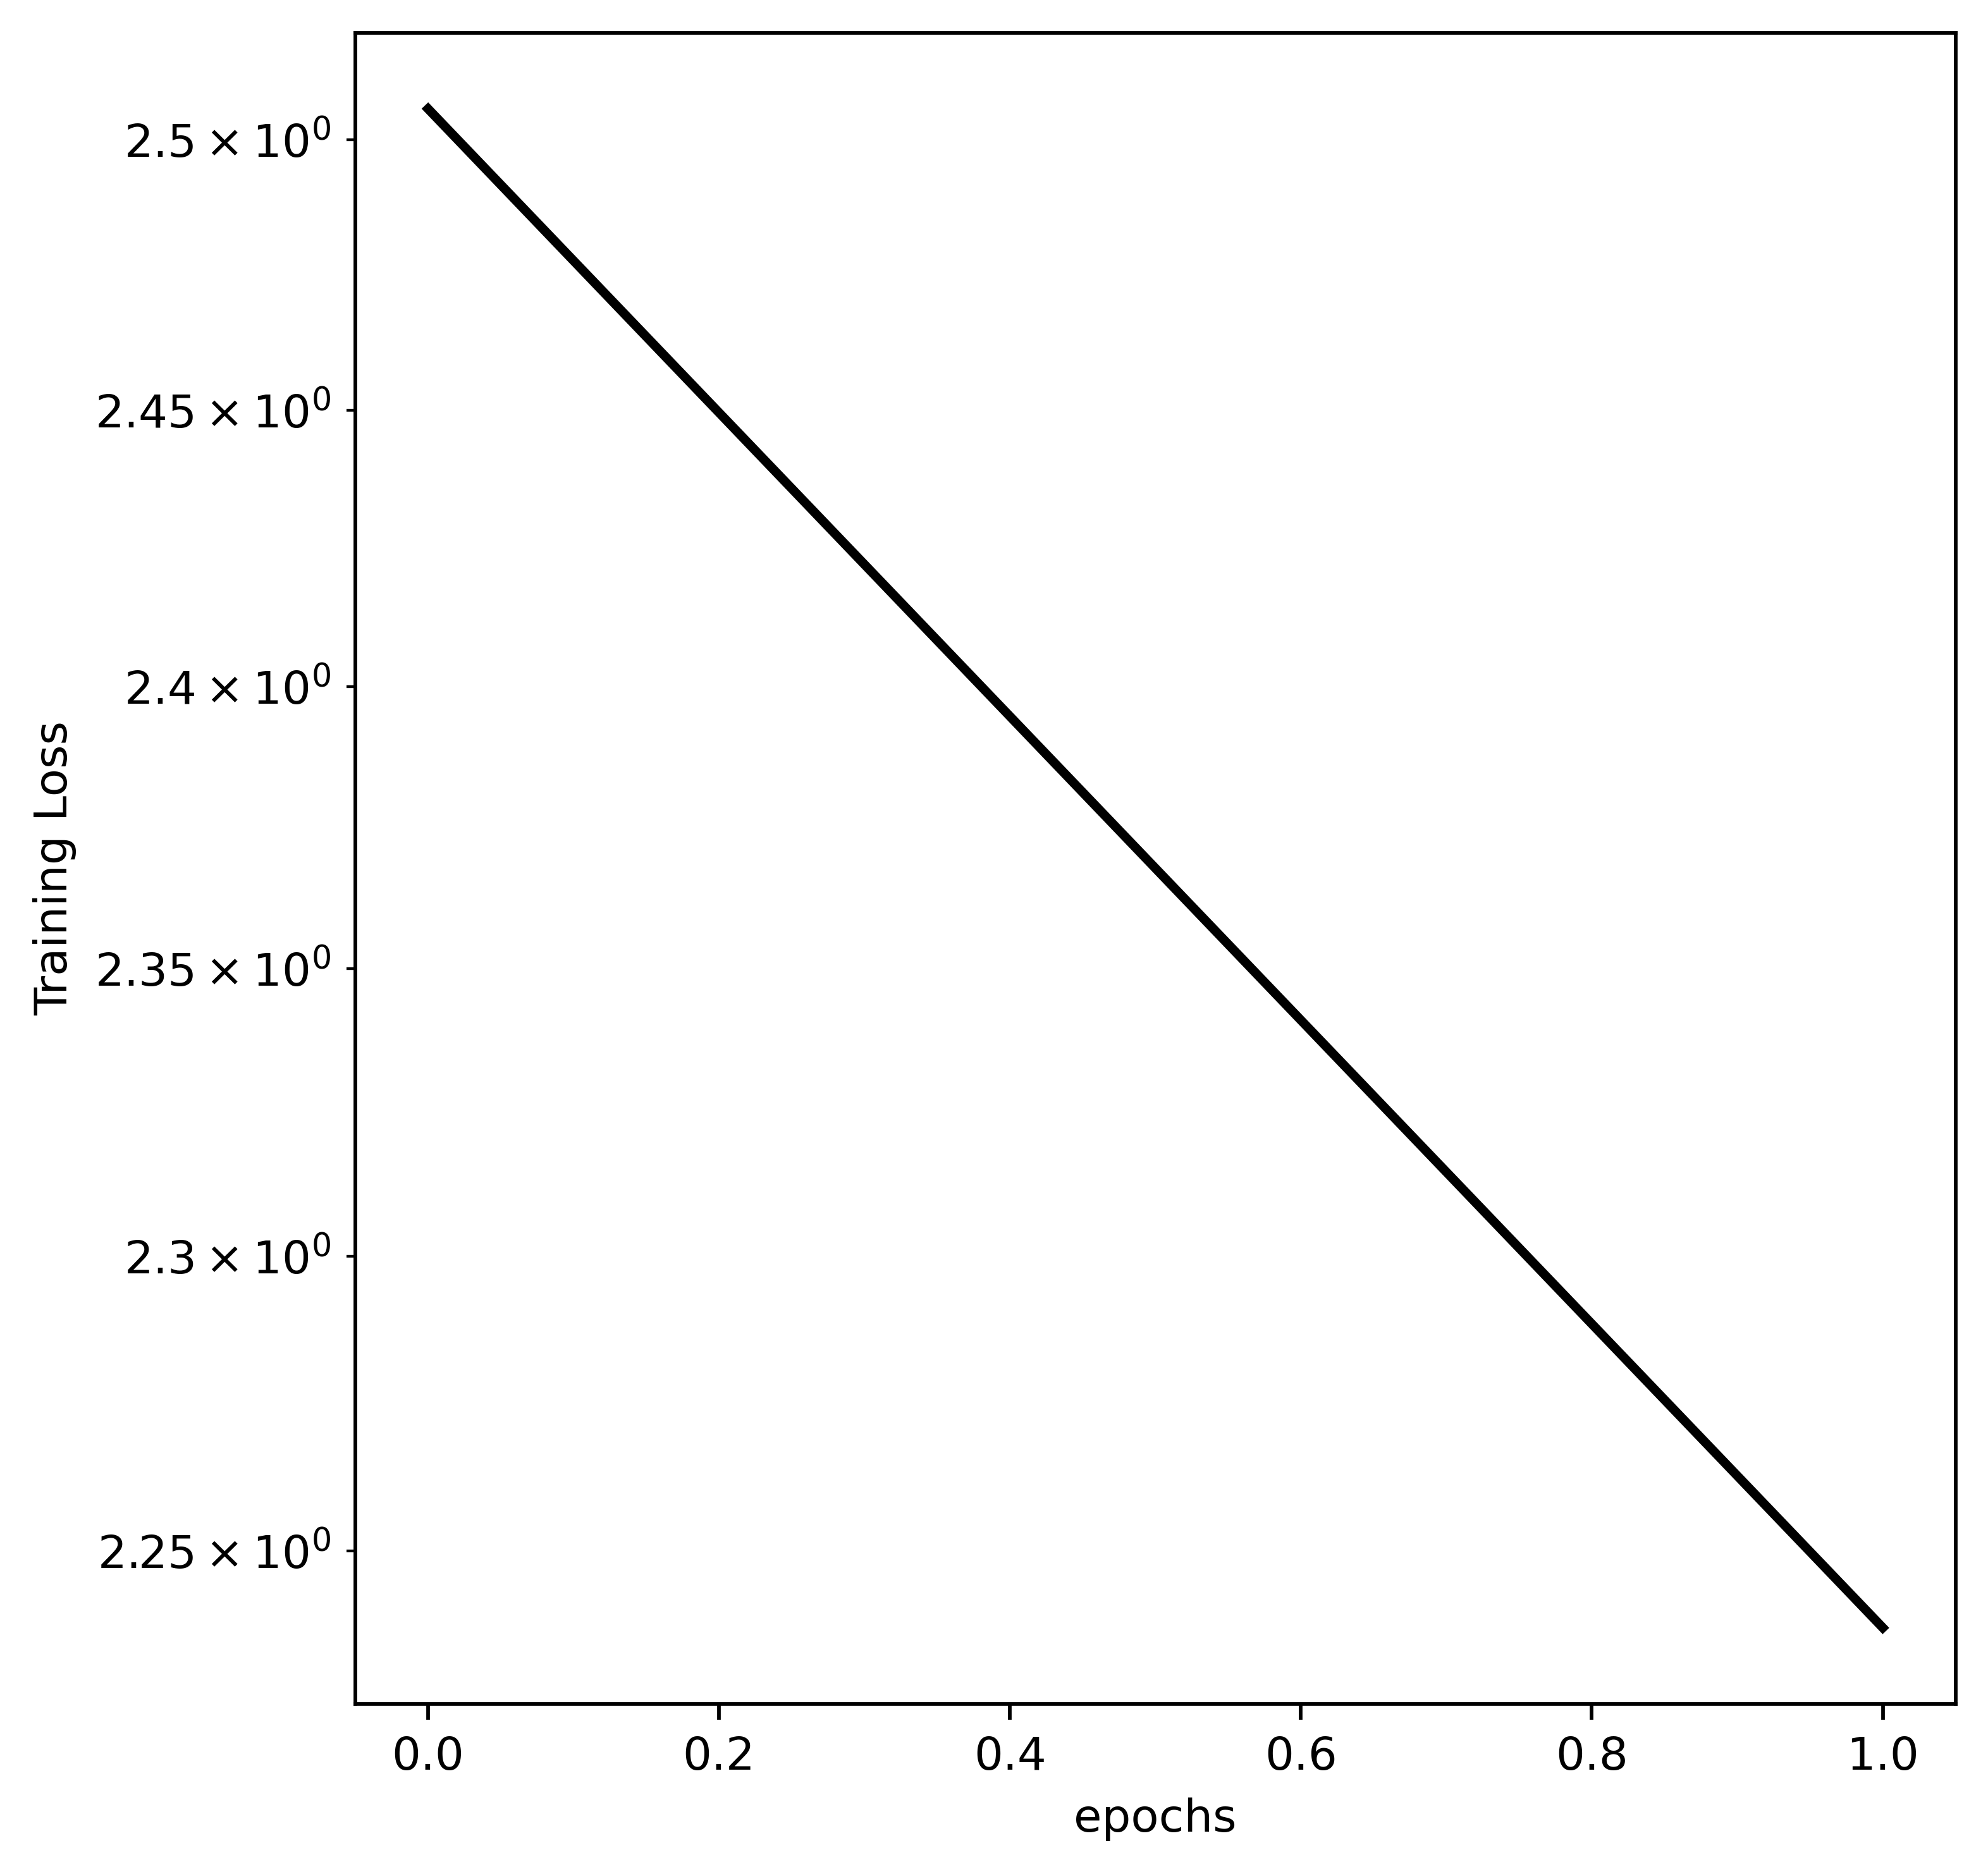

In [94]:
loss = history.history['loss']
epochs = range(len(loss))
plotLoss(epochs,loss,outDir)

In [95]:
dataset_val = windowed_dataset_predict(scaled_Data,window_size, btch_sz)
dataSetX_val, dataSetY_val = dataSet_numpy(btch_sz,window_size,scaled_Data.shape[1],dataset_val)

(4528, 20, 15)
(4528, 12)


**Response Prediction**

In [96]:
def predict(model,gtm_trj_ToBe_scaled,dataSetX_val,dataSetY_val,btchSize=32):
    forecast = []
    forecast = np.zeros((1,dataSetY_val.shape[1]))
    forecast =np.append(forecast,model.predict(dataSetX_val,batch_size=btchSize),axis=0)
    forecast = np.delete(forecast,(0),axis=0)
    for i in range(dataSetY_val.shape[1]):
        forecast[:,i] = scalingbk_Stand(forecast[:,i],gtm_trj_ToBe_scaled.iloc[:,i])
    
    return forecast

In [97]:
surrogateModel = load_model('surrogate.h5')
predictedData = predict(surrogateModel,gtm_trj_ToBe_scaled,dataSetX_val,dataSetY_val,btch_sz)
np.savetxt("CLSTM_PredictedProjectionV0TCM.csv", predictedData, delimiter=",")


In [98]:
def plotResponse(predictedData,orignalData,Steps,InitialTime,TotalTime,windowSize,deltaT,outDir):
    if os.path.isdir(outDir):
        pass
    else:
        os.mkdir(outDir)
    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    LegendFont = matplotlib.font_manager.FontProperties(family="DejaVu Sans",
                                    weight="bold",
                                    style="normal", size=10)
    time_array = np.linspace(InitialTime+(windowSize*deltaT),TotalTime,num=Steps-windowSize)
    plt.plot(time_array,predictedData[:,0],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,0],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('u (ft/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "u_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,1],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,1],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('v (ft/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "v_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,2],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,2],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('w (ft/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "w_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,3],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,3],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('p (rad/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "p_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))


    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,4],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,4],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('q (rad/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "q_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,5],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,5],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('r (rad/s)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "r_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))


    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,6],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,6],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('pdot (rad/s^2)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "pdot_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))


    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,7],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,7],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('qdot (rad/s^2)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "qdot_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))


    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,8],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,8],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('rdot (rad/s^2)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "rdot_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,9],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,9],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('Latitude (ft)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "Latitude_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,10],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,10],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')
    plt.xlabel('Time (s)')
    plt.ylabel('Longitude (ft)')
    fig.tight_layout()
    plt.legend(loc='upper center',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "Longitude_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))


    fig = plt.figure(figsize=[5.8,5.8],dpi=520)
    plt.plot(time_array,predictedData[:,11],linestyle='-',color="k",antialiased=True,linewidth=2.0, label ='ML')
    plt.plot(time_array,orignalData[windowSize:,11],linestyle='--',color="r",antialiased=True,linewidth=2.0, label ='TCM')

    plt.xlabel('Time (s)')
    plt.ylabel('Altitude (ft)')
    fig.tight_layout()
    plt.legend(loc='upper right',frameon=False,prop=LegendFont,markerscale=1,handlelength=3)

    FileOut = "Altitude_ML.png"
    plt.savefig(os.path.join(outDir,FileOut))

    '''ax = fig.add_subplot()
    x_axisfont = {'fontname':"Calibri"} # see note below for family font list
    y_axisfont = {'fontname':"Calibri"}
    number_font = {'fontname':'cmb10'}'''

**Plotting the predicted response and save in the output directory**

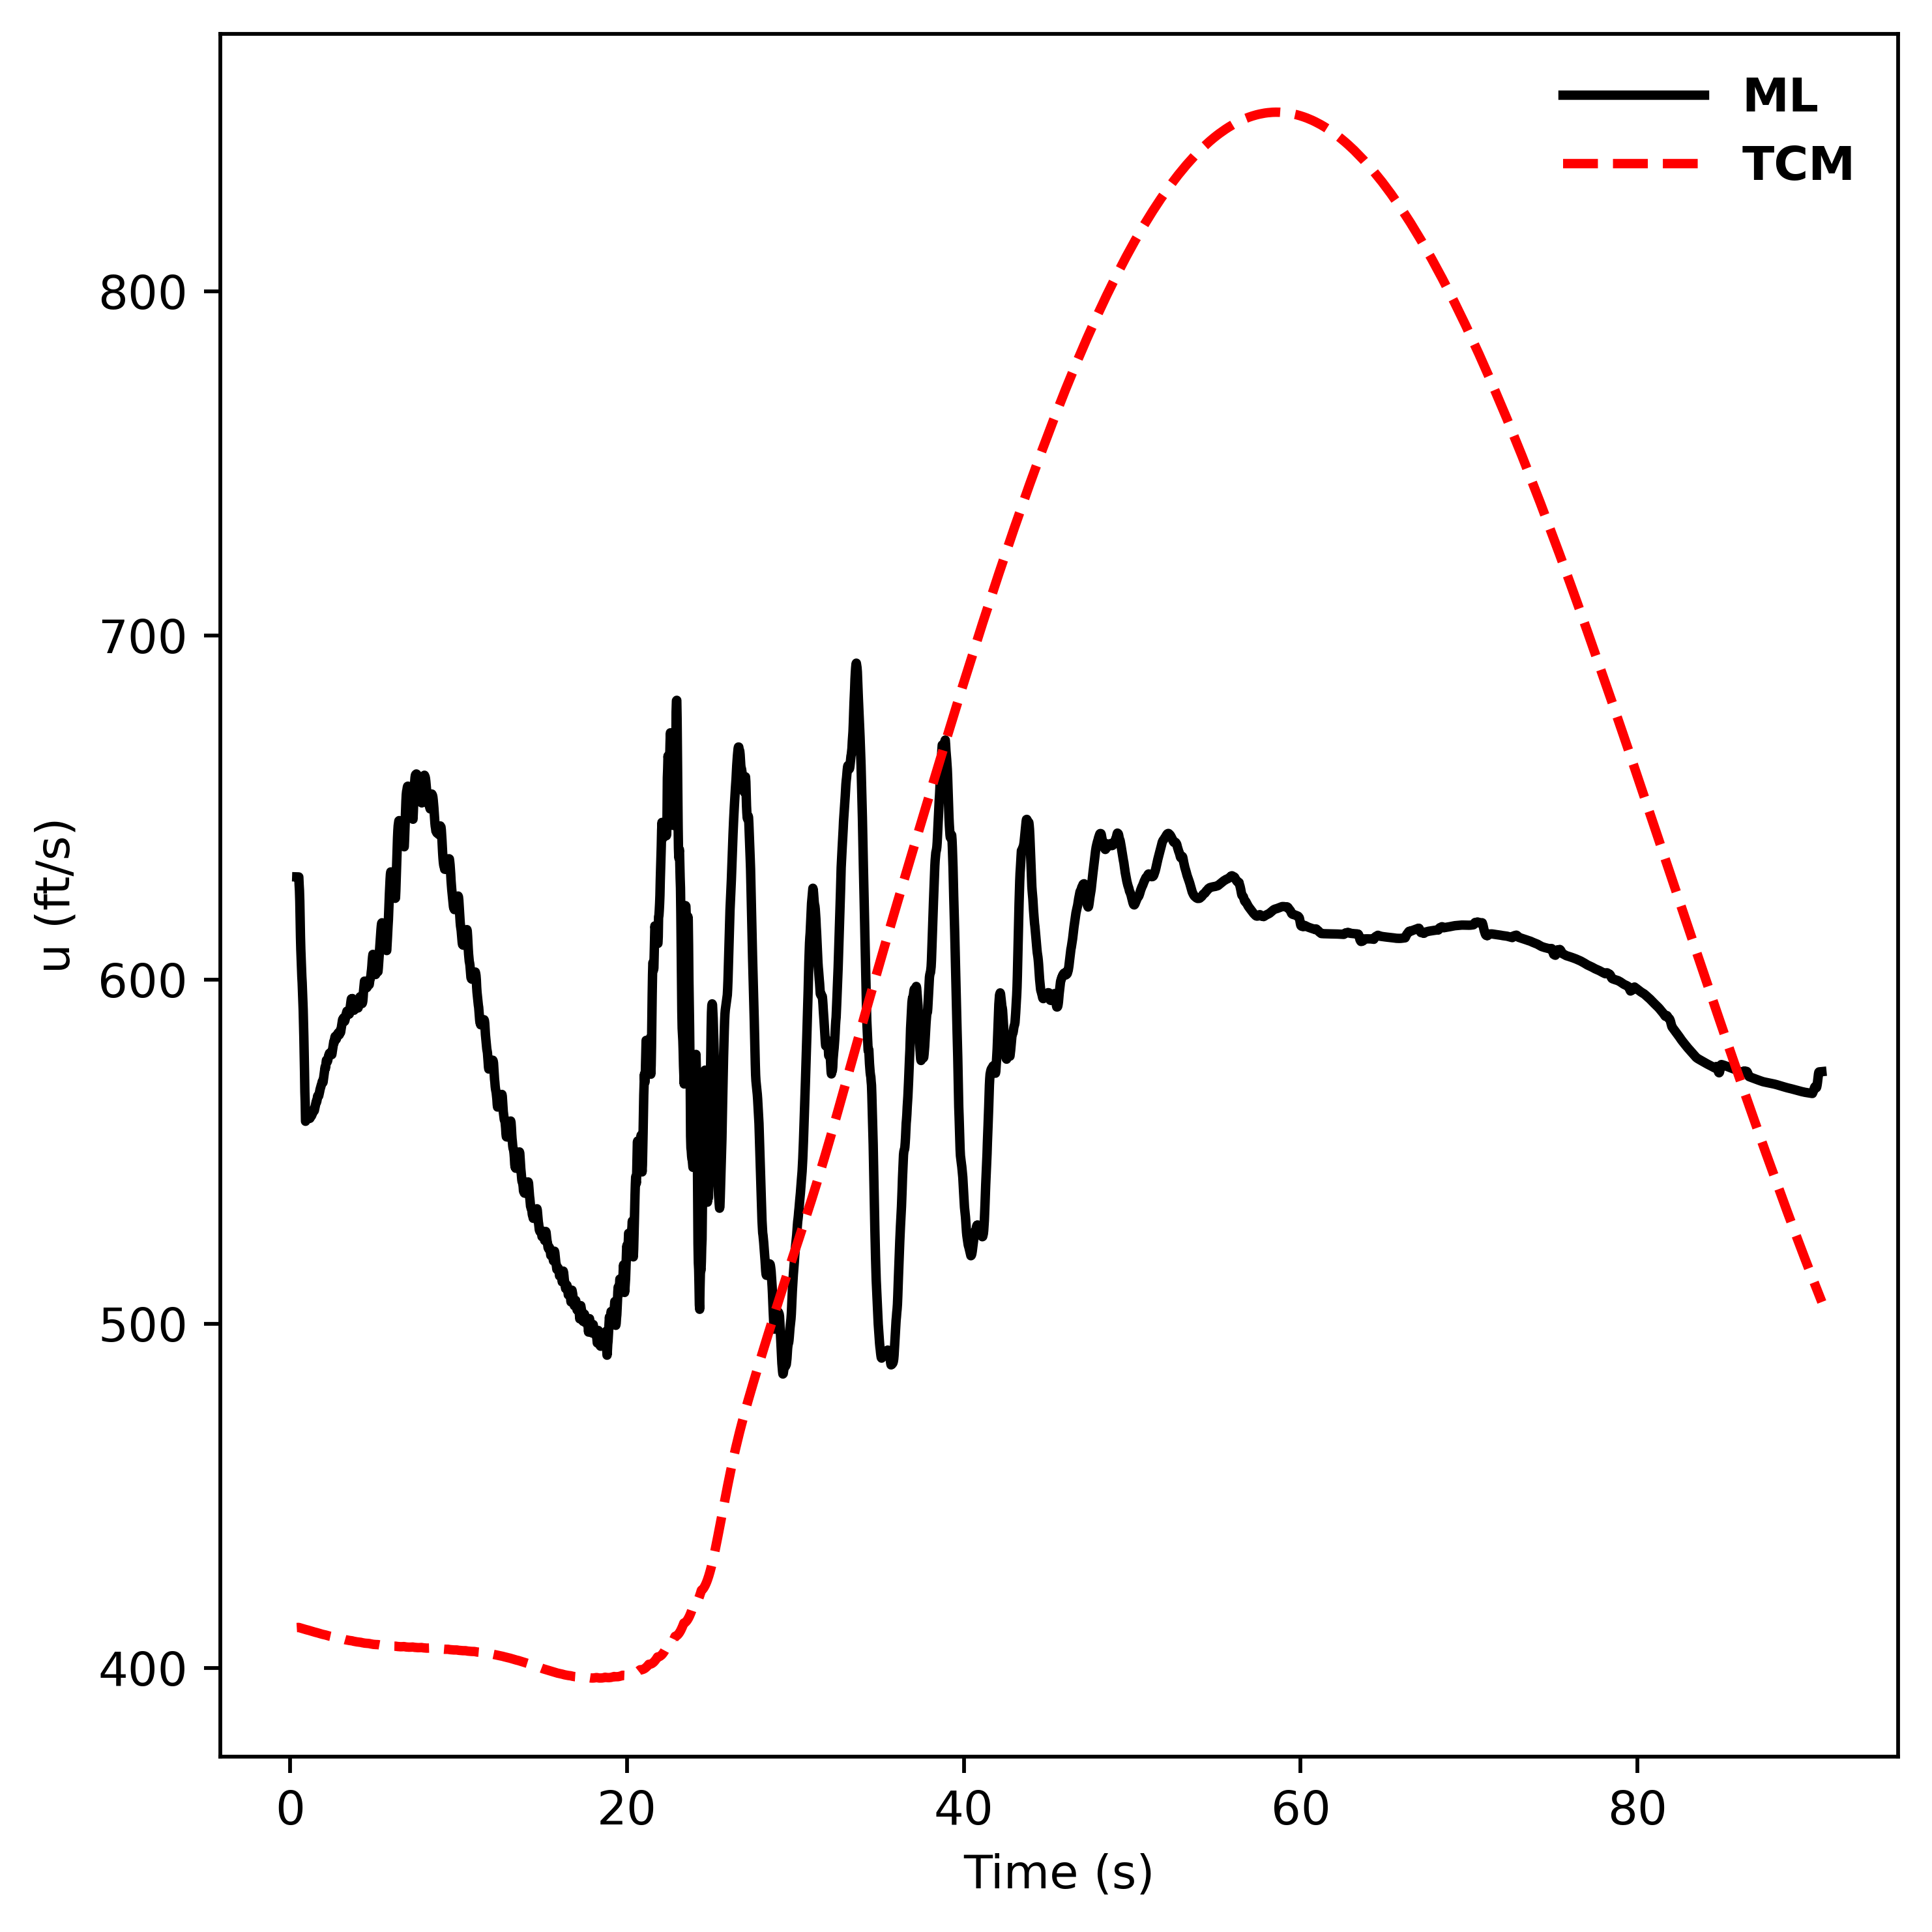

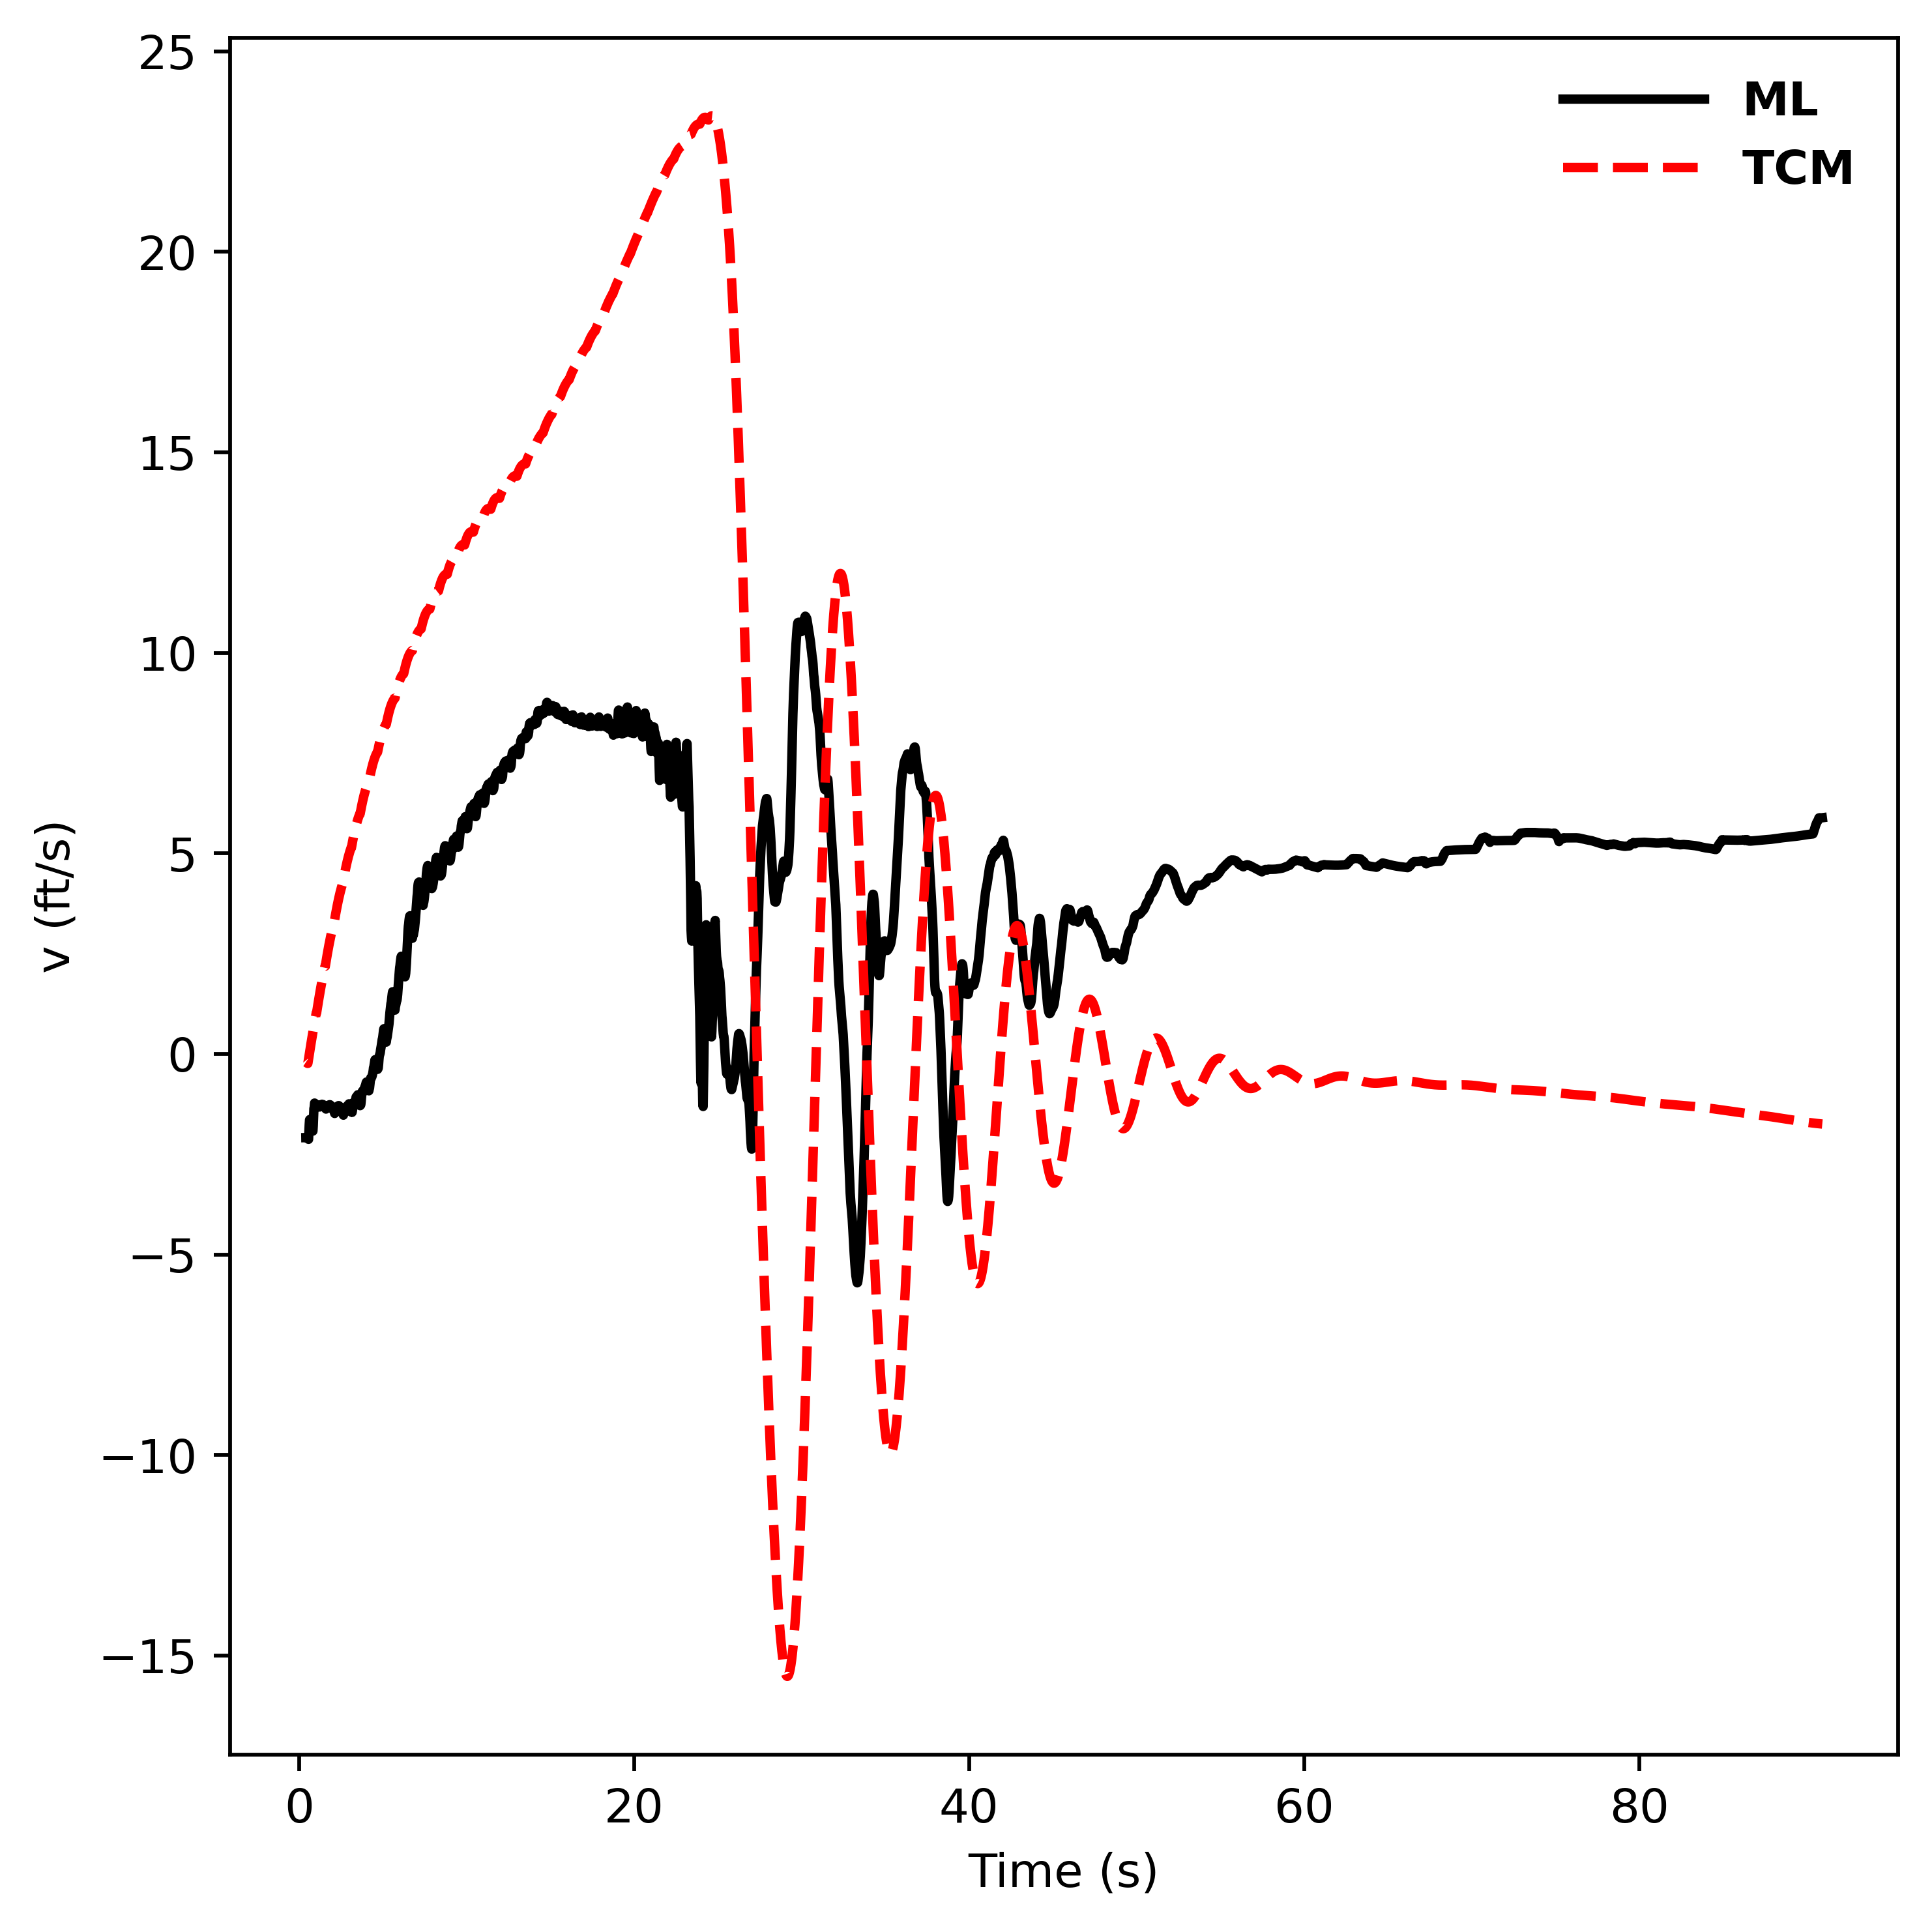

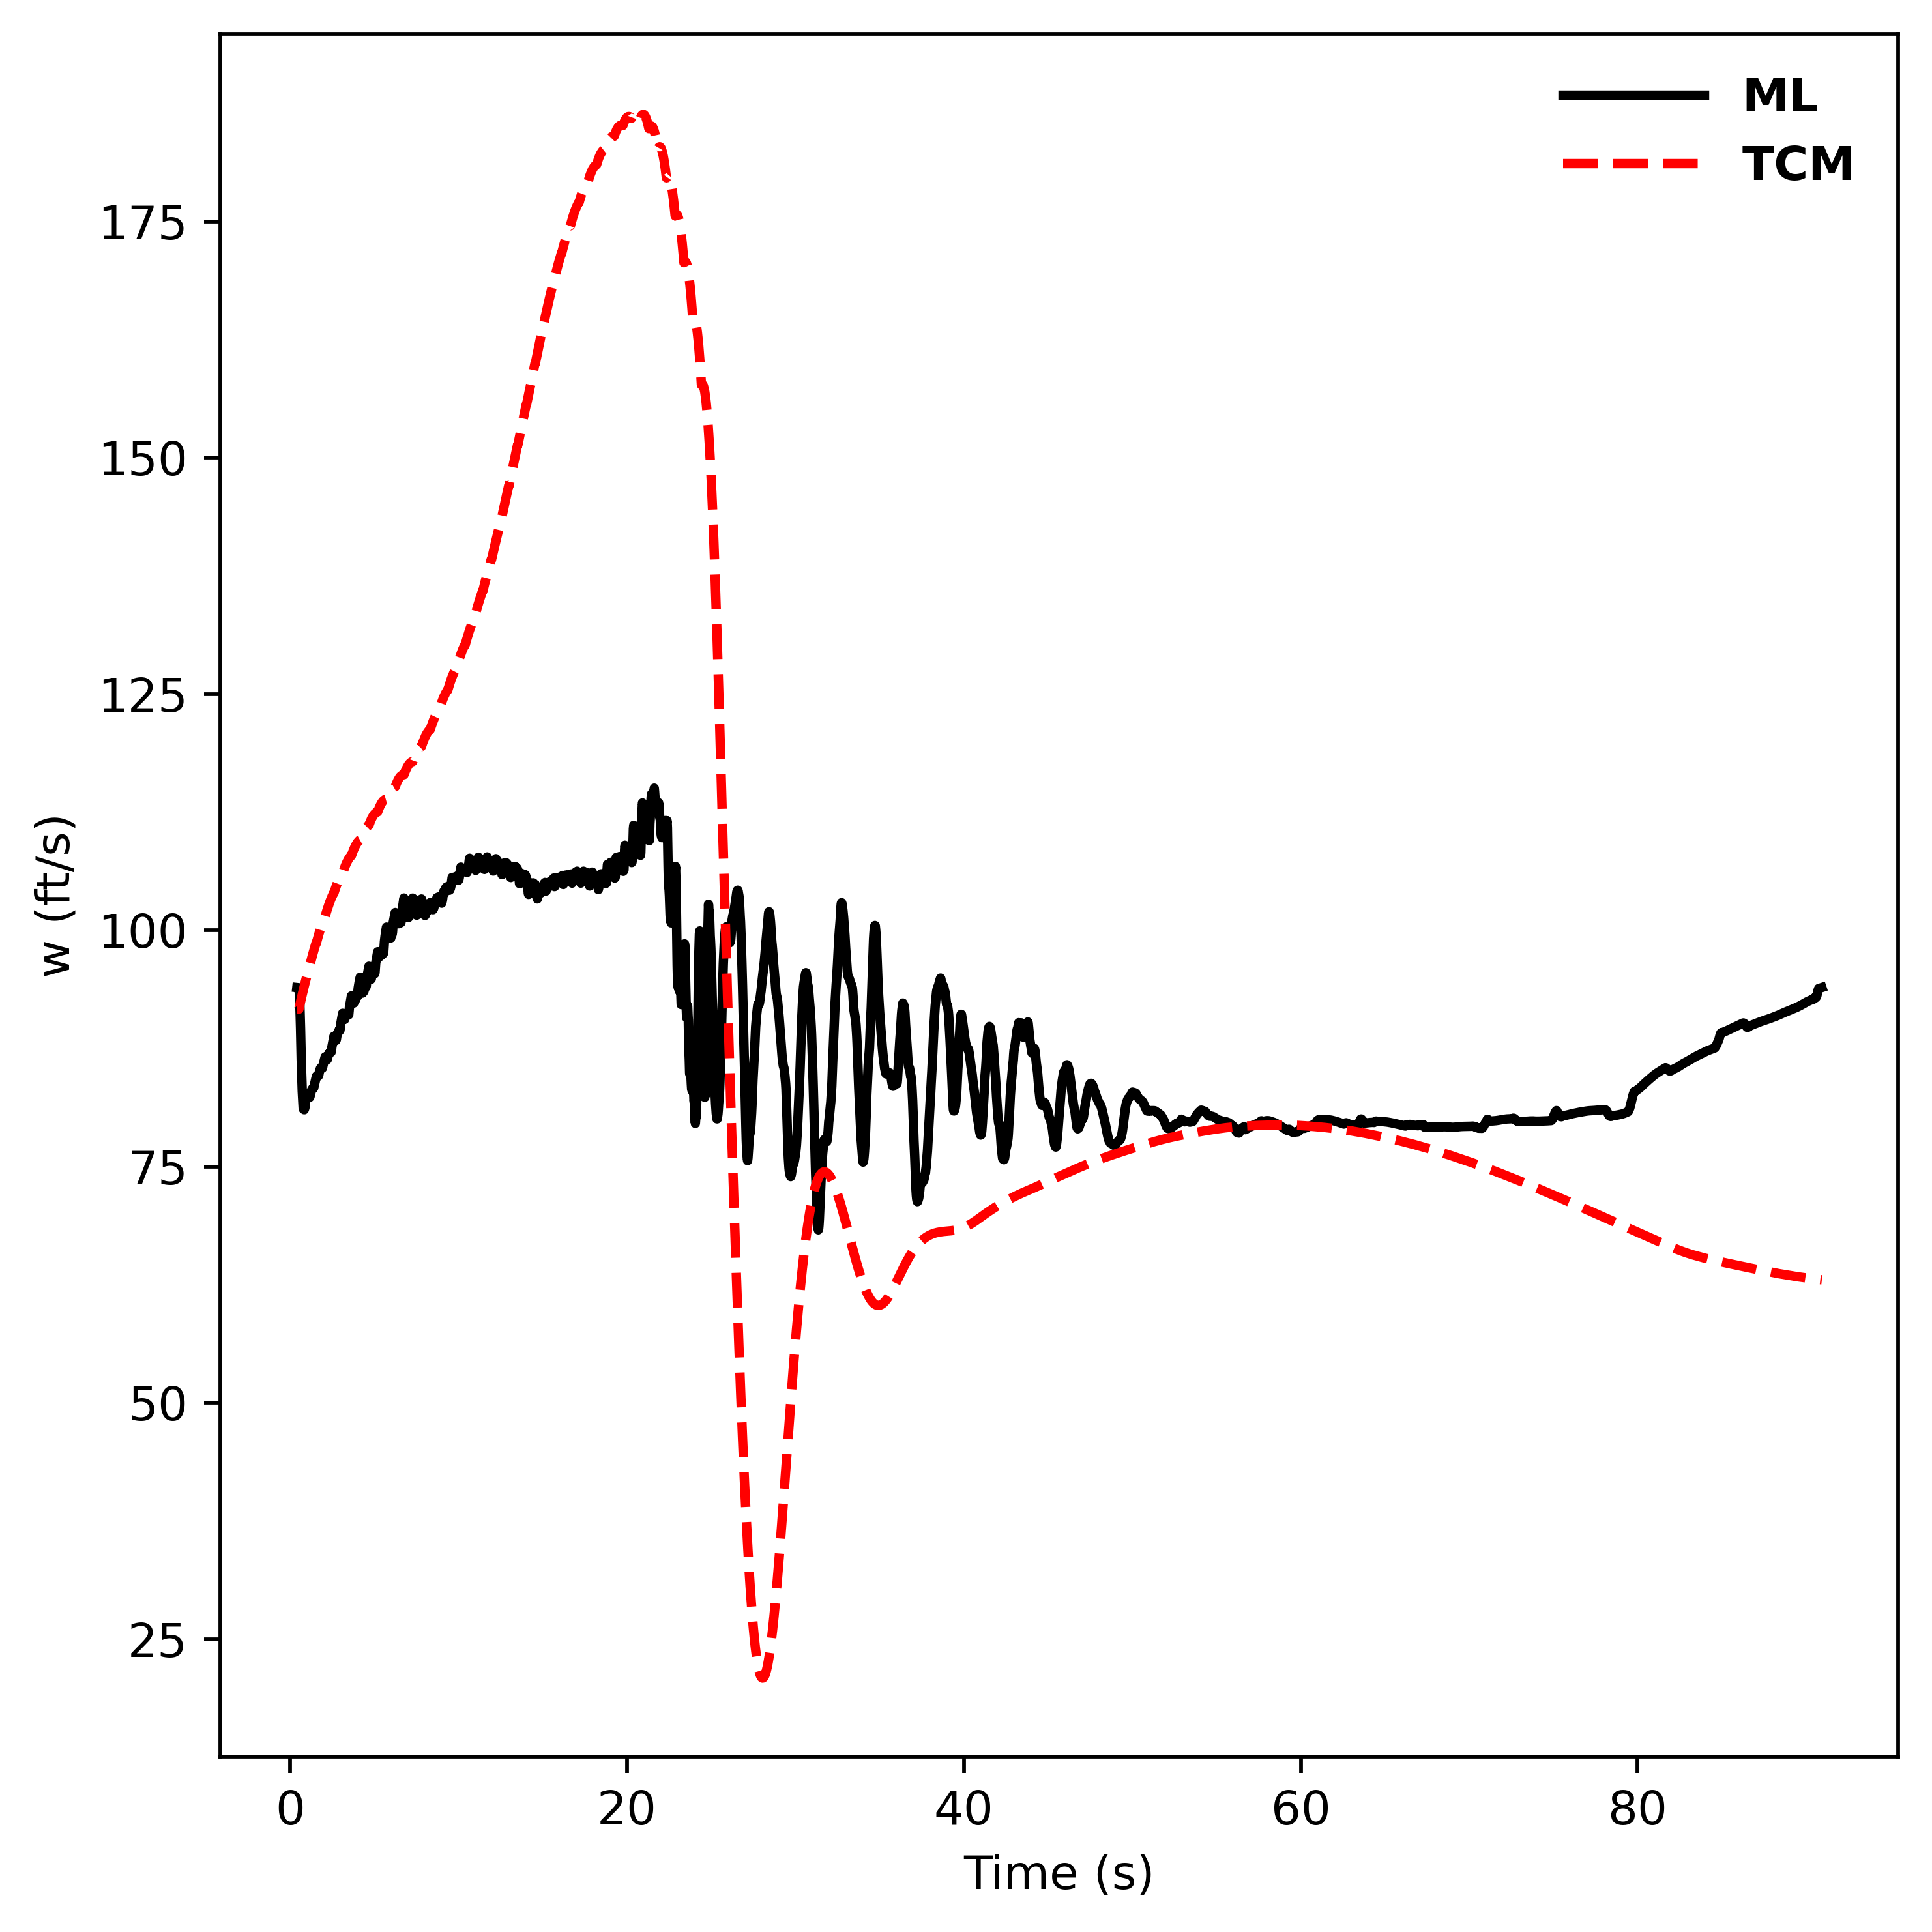

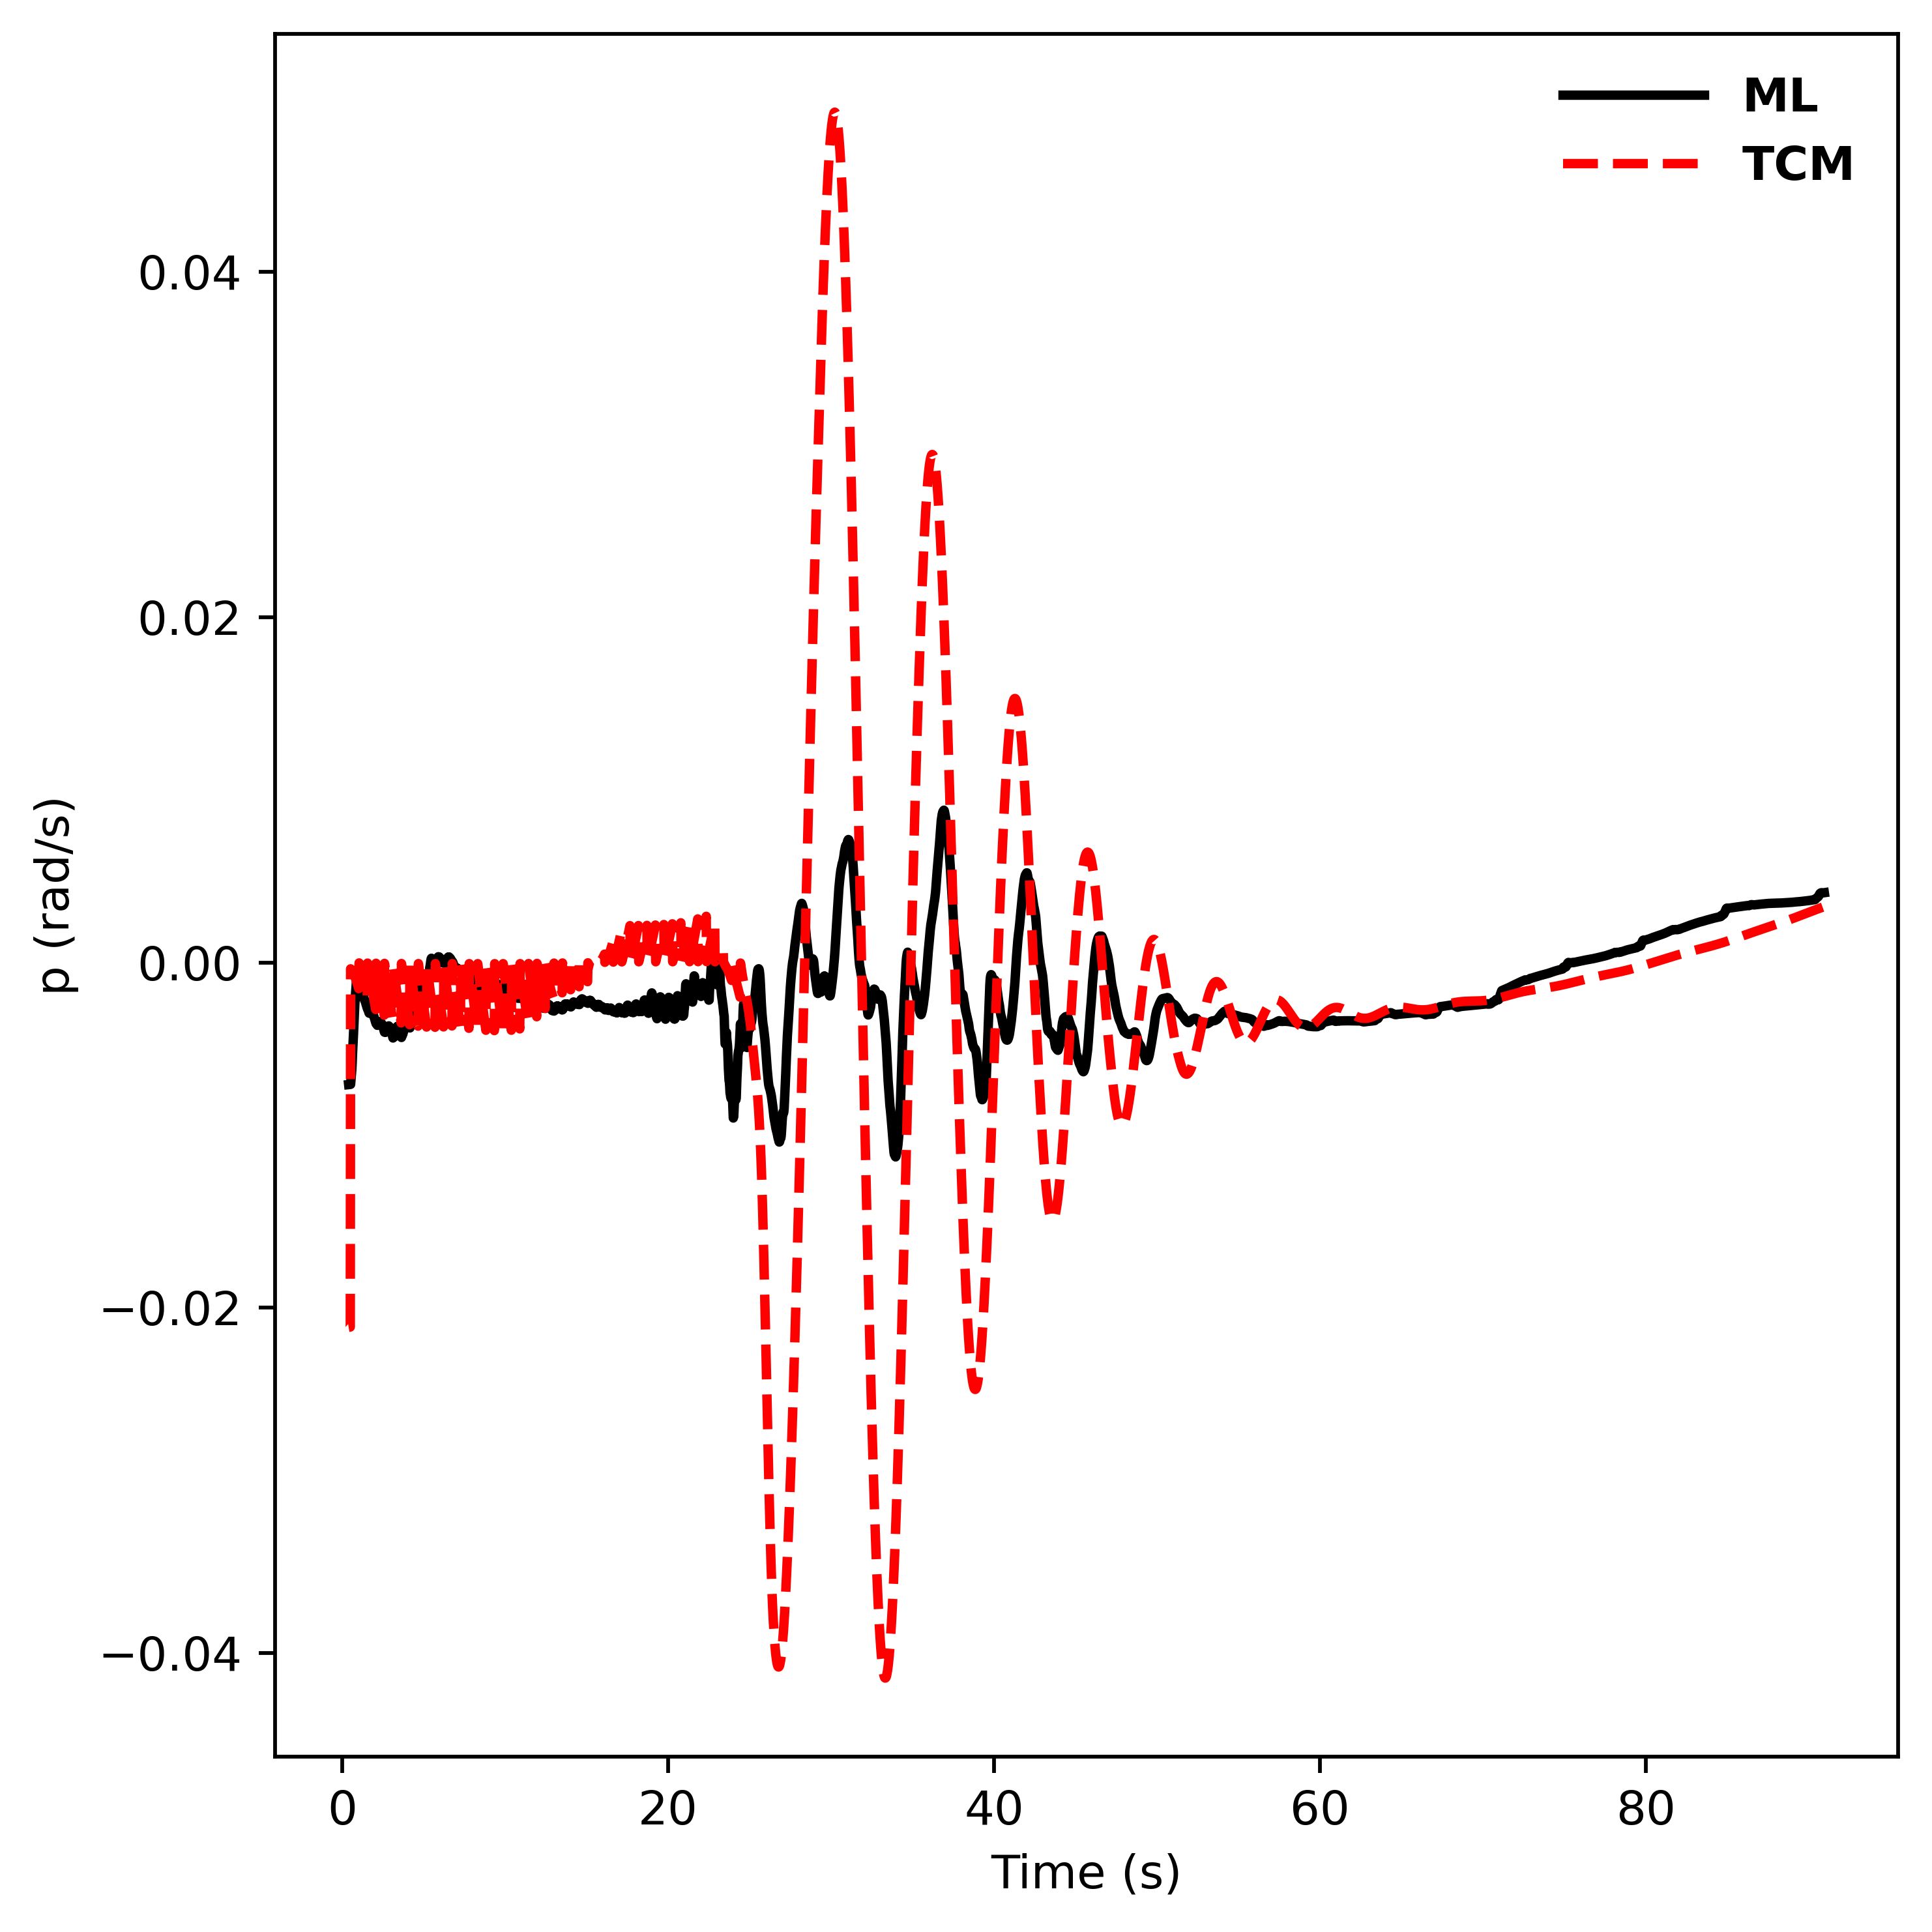

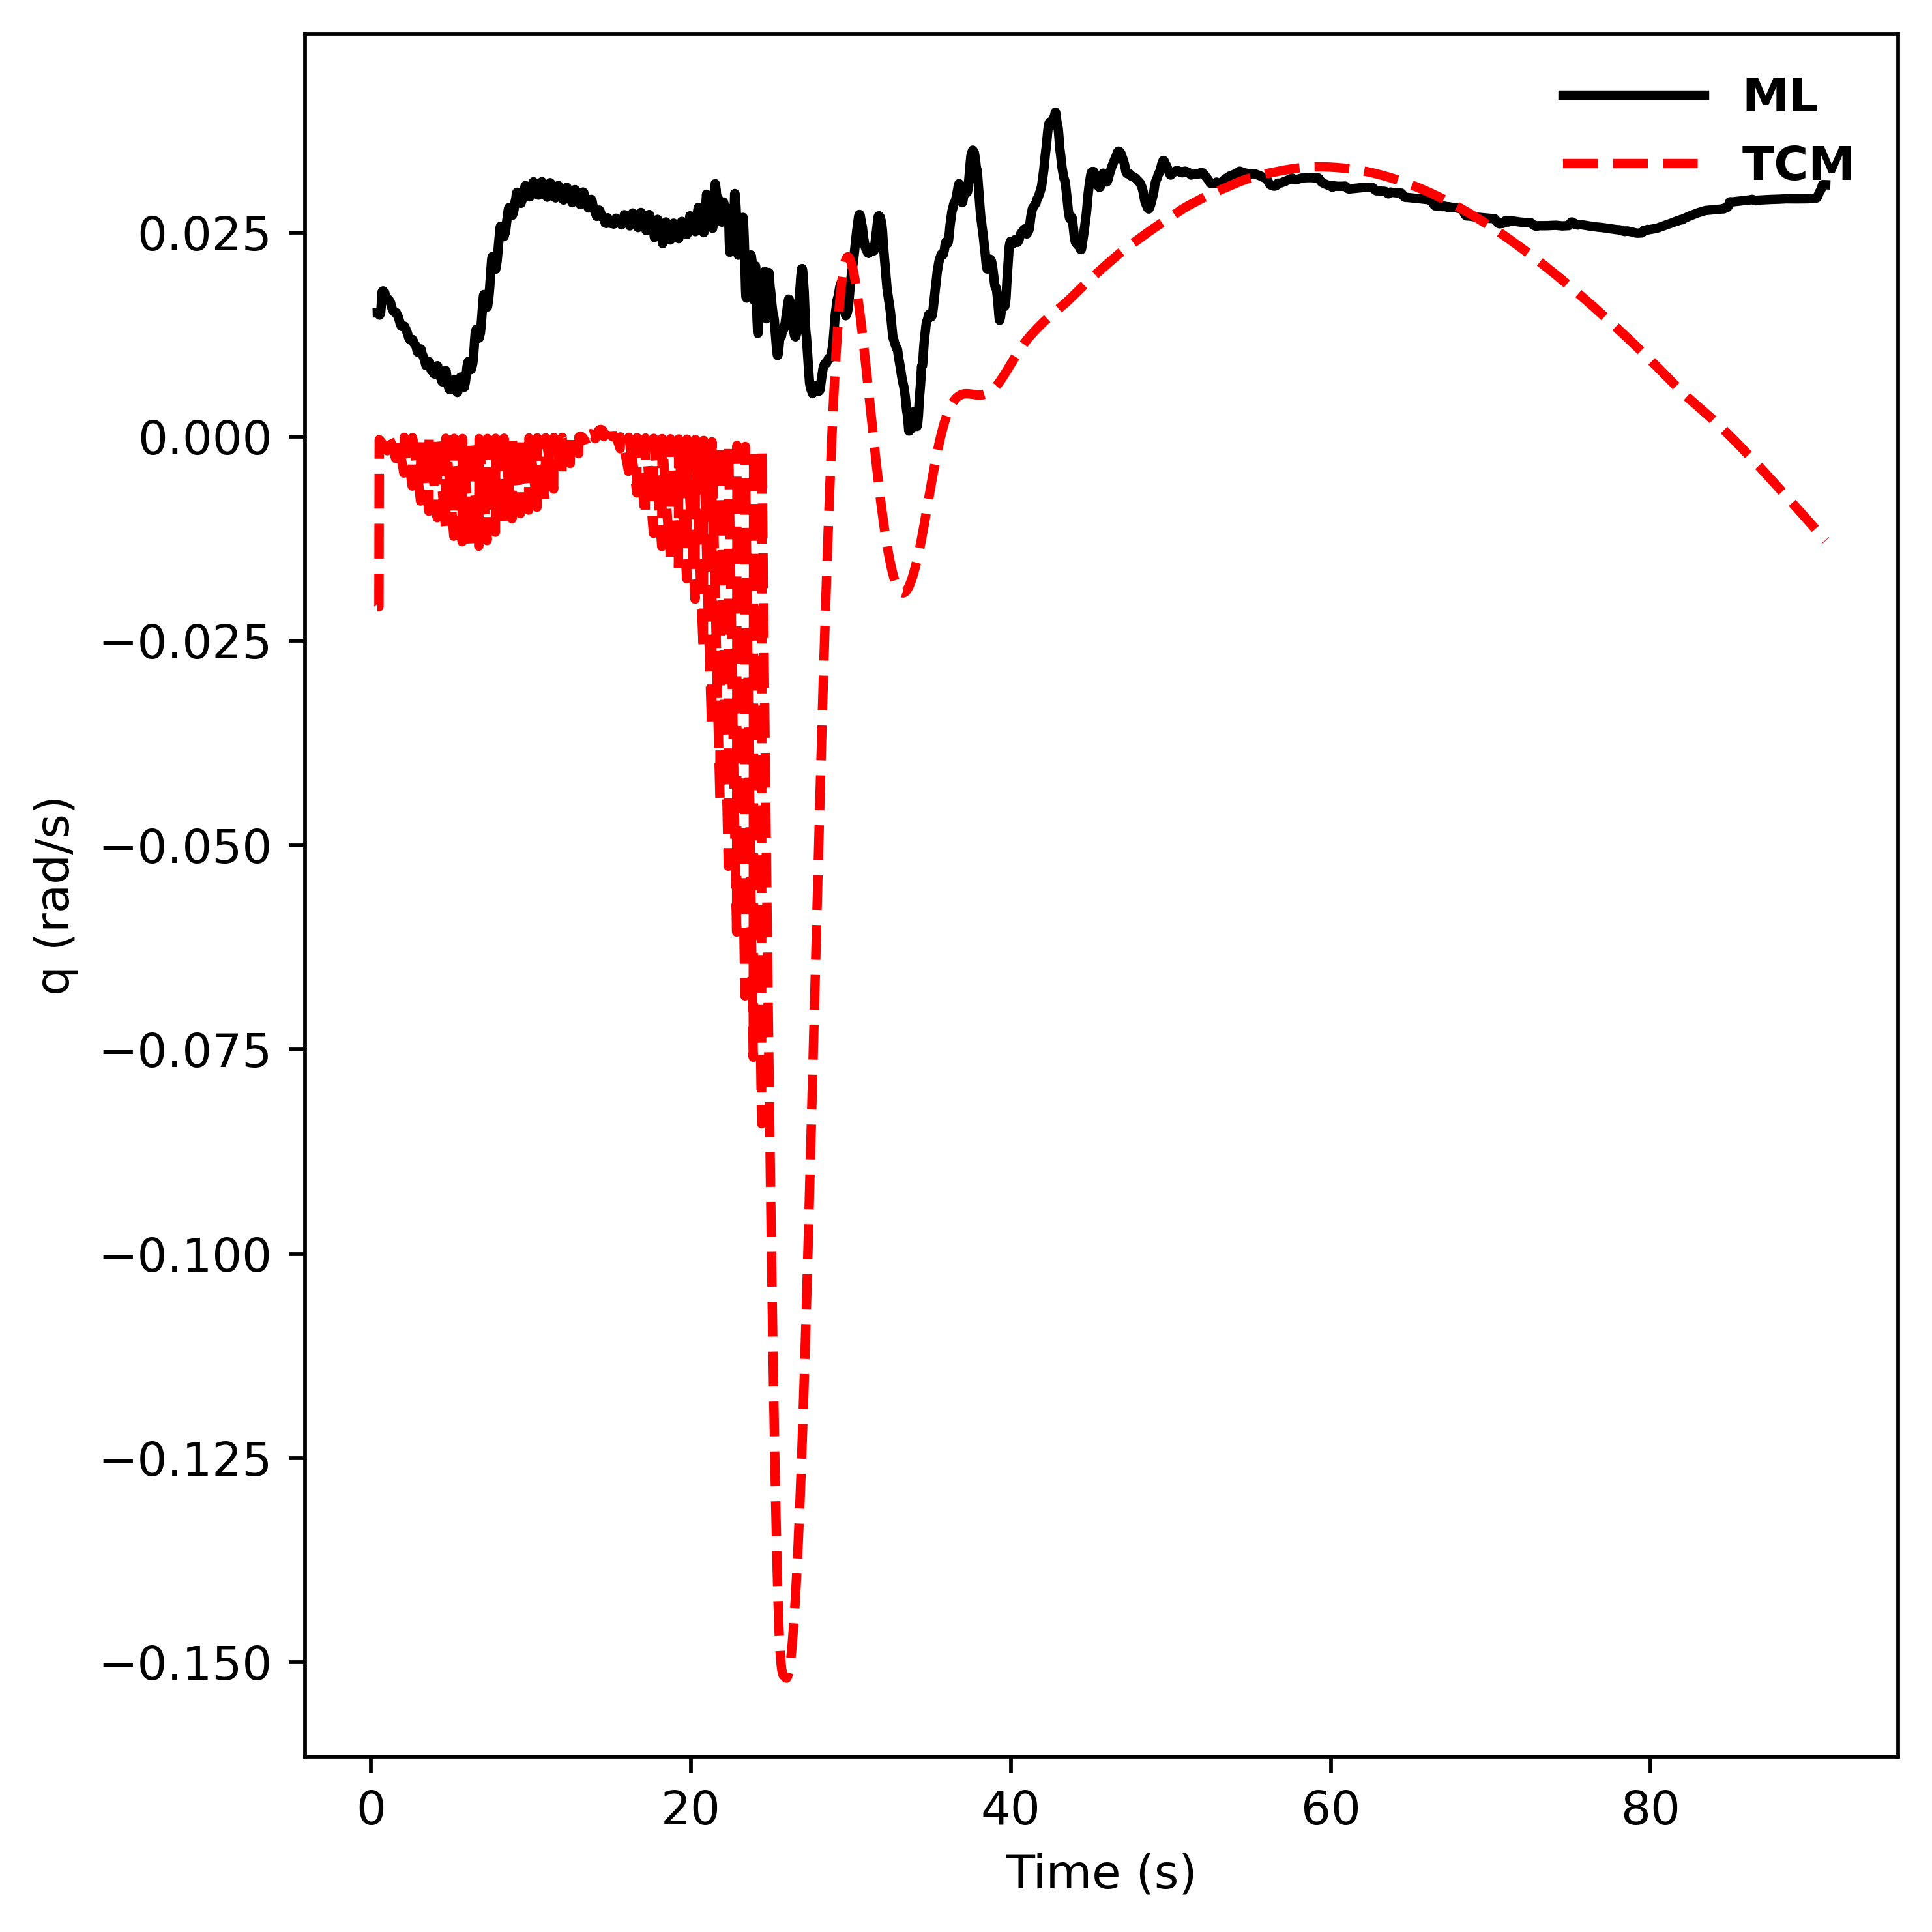

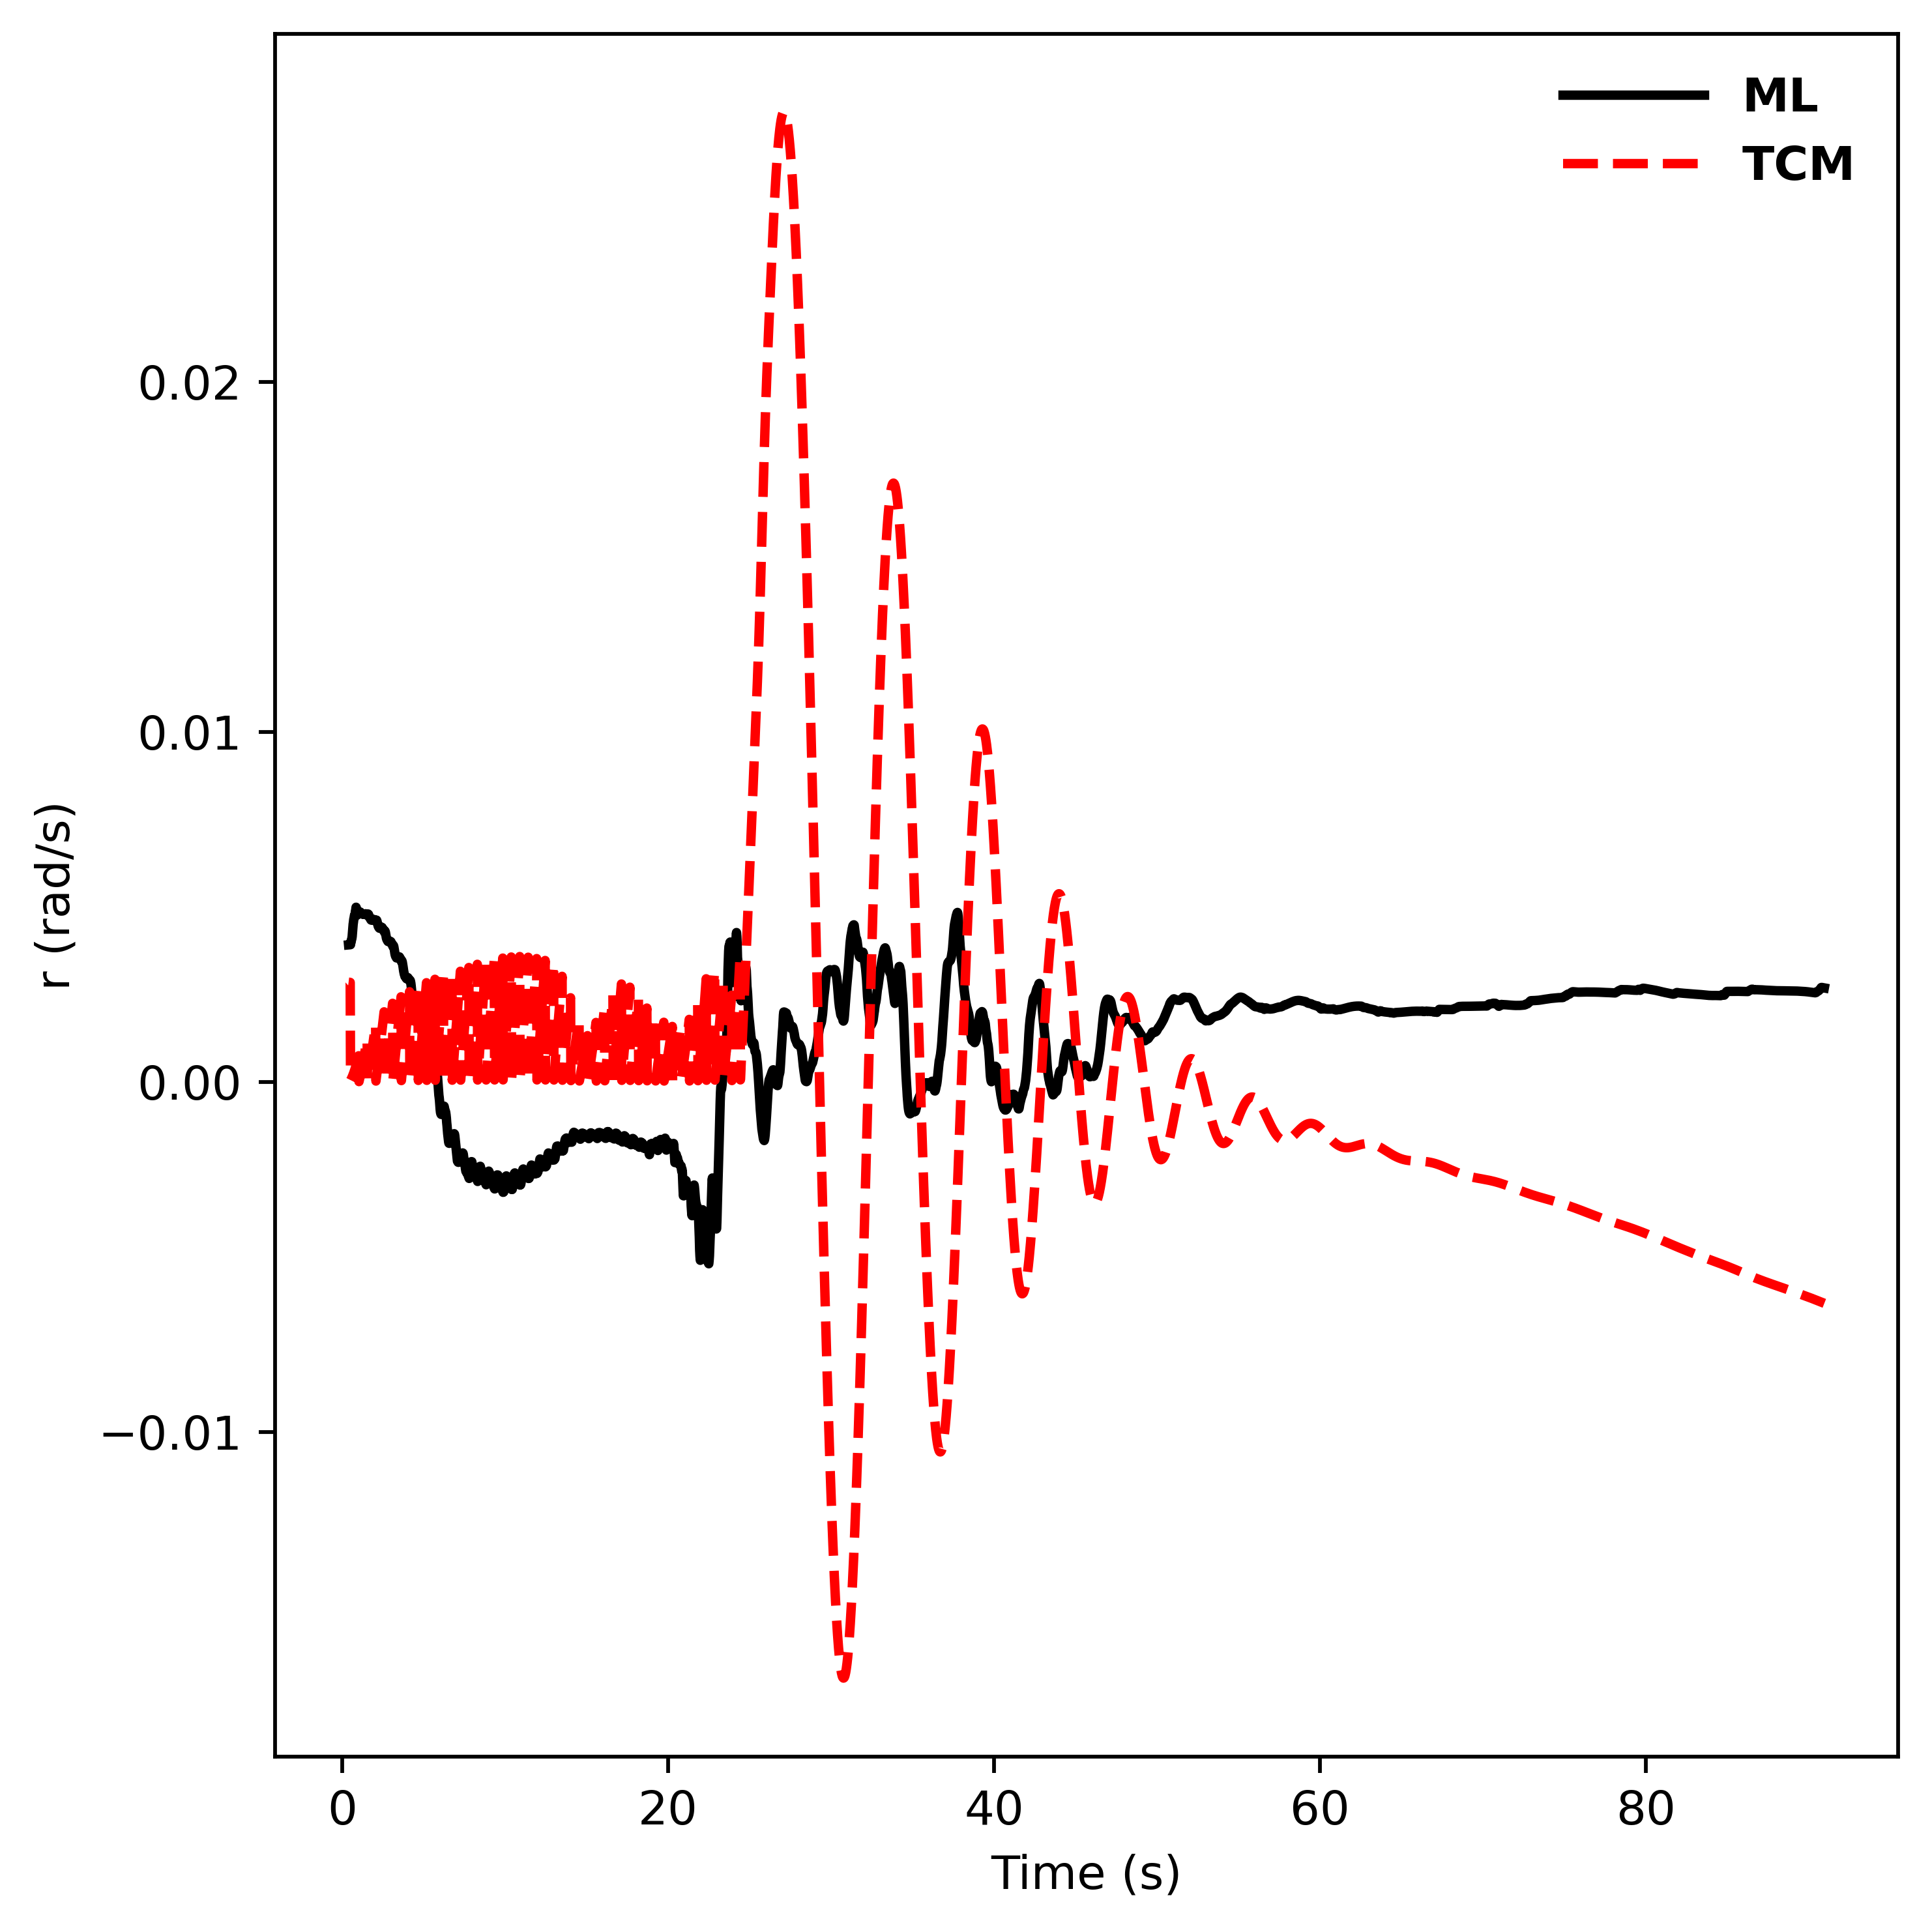

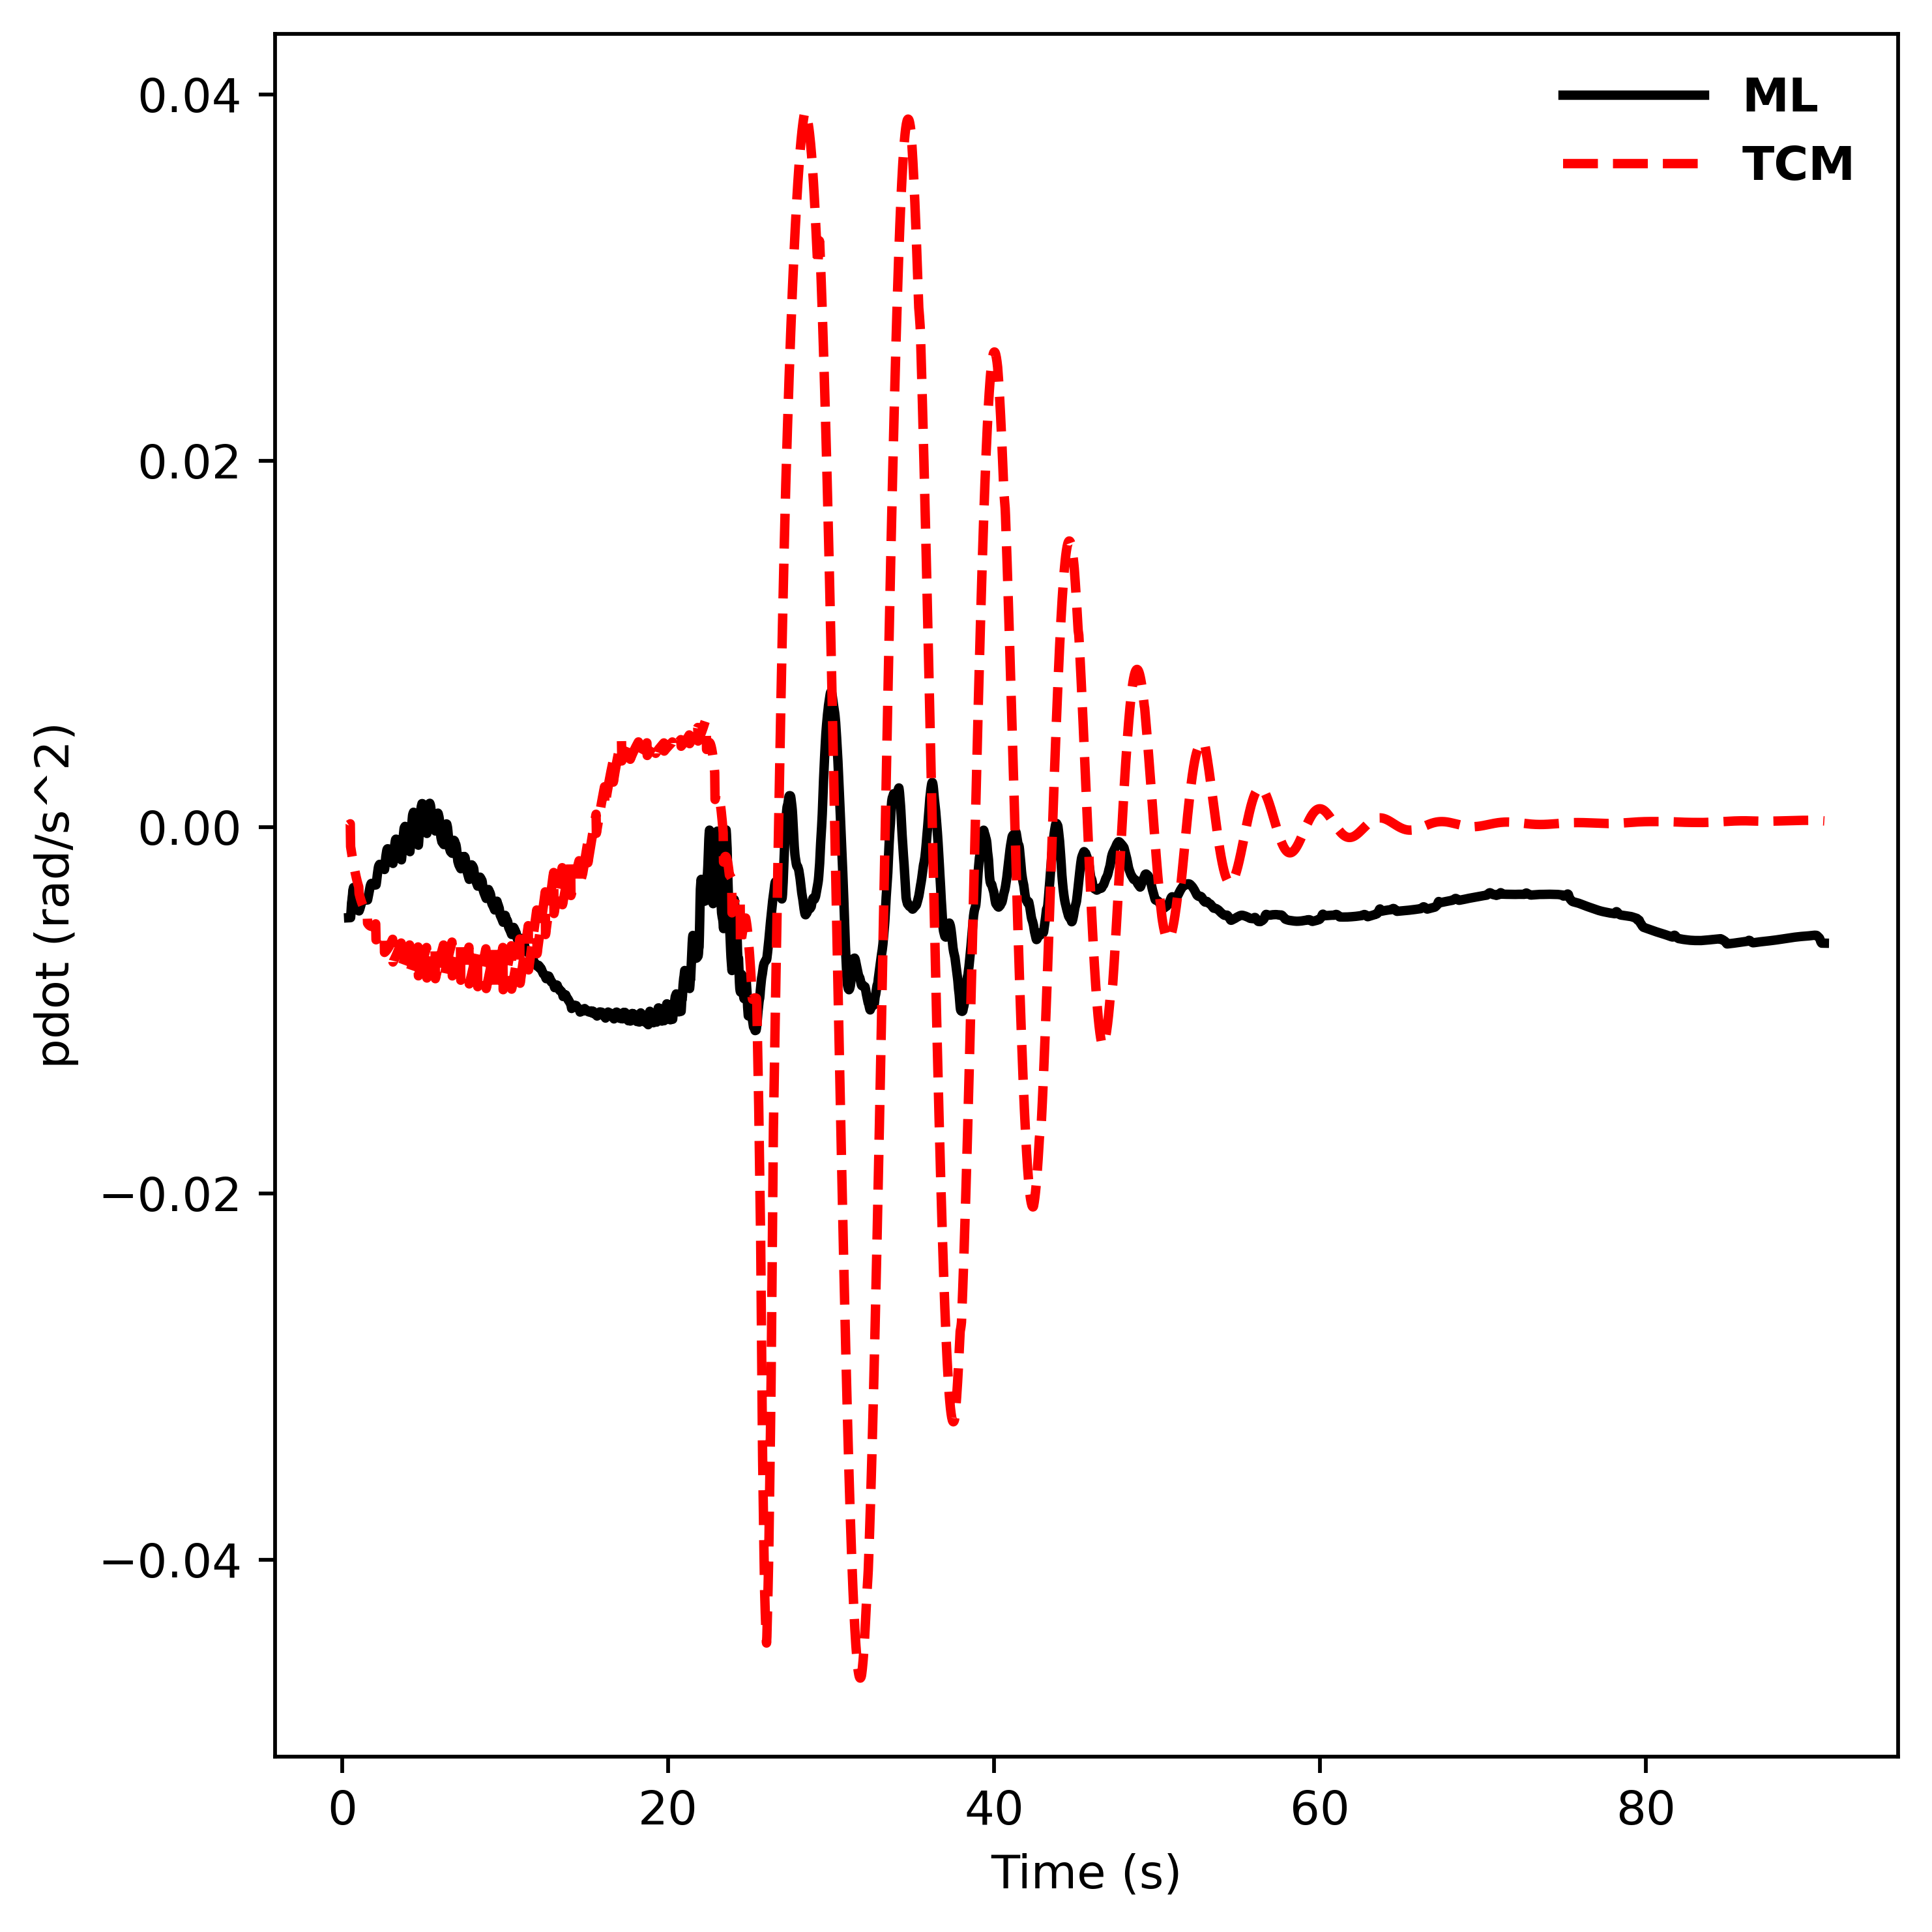

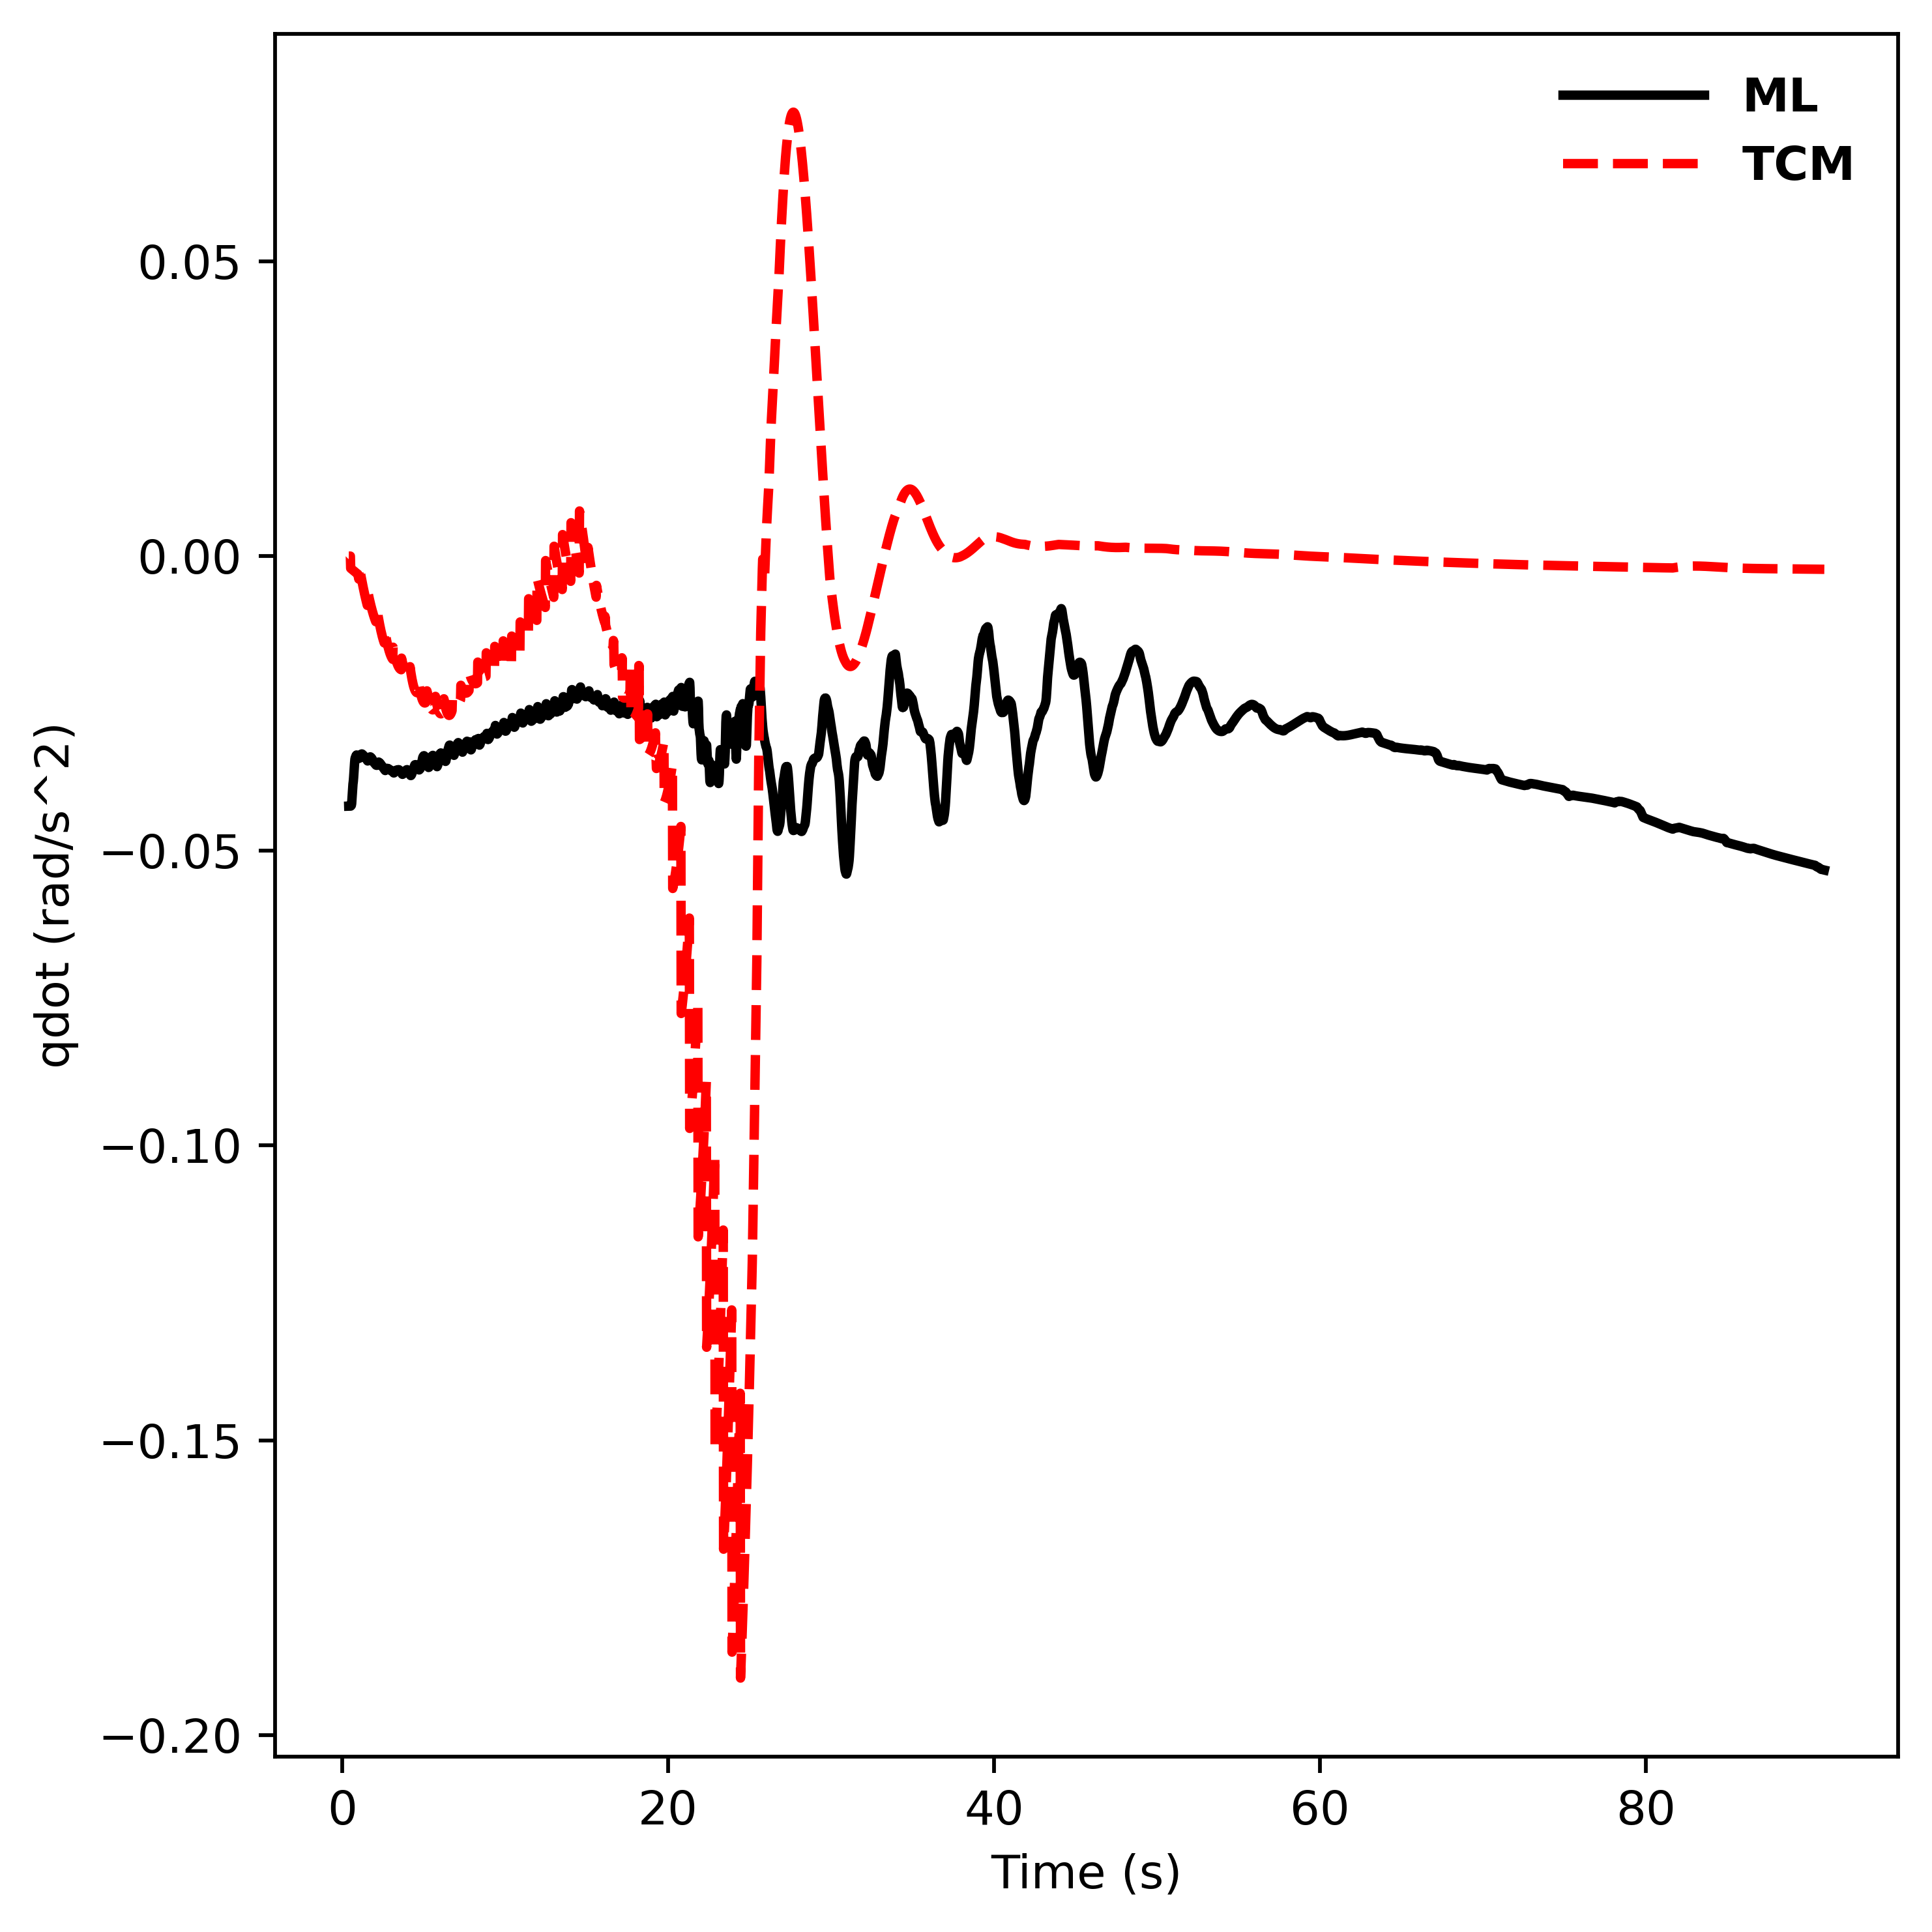

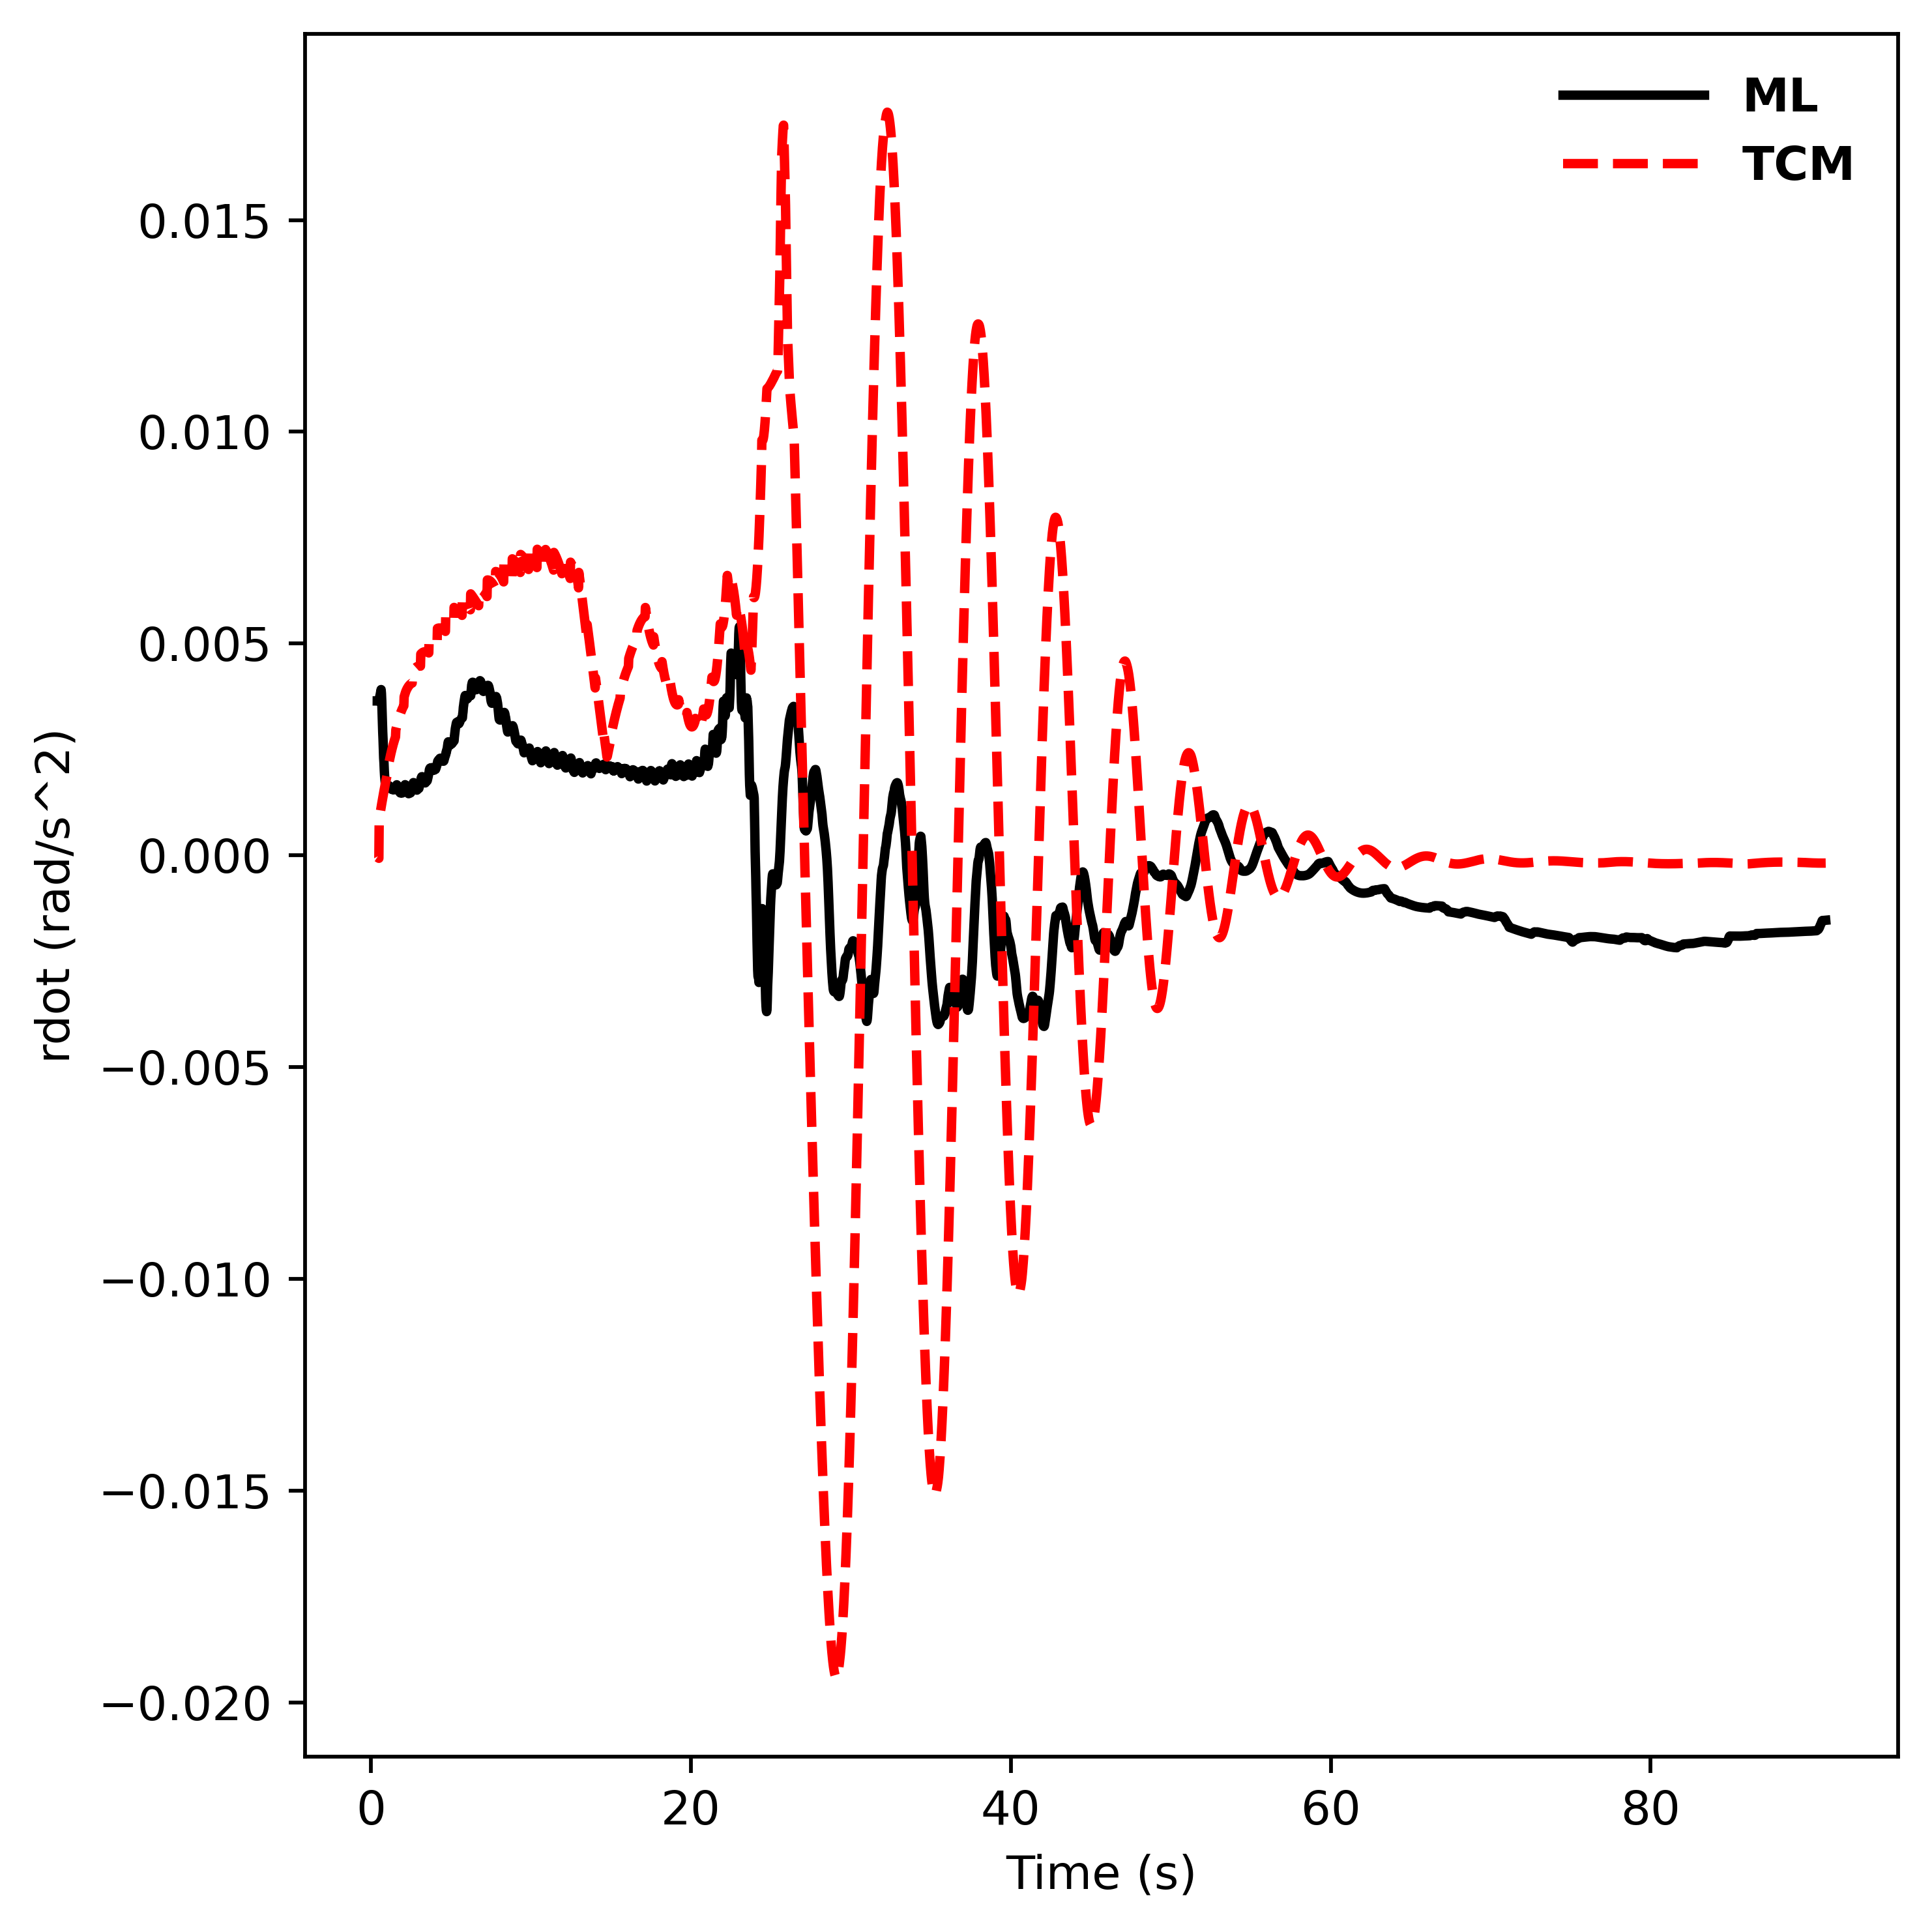

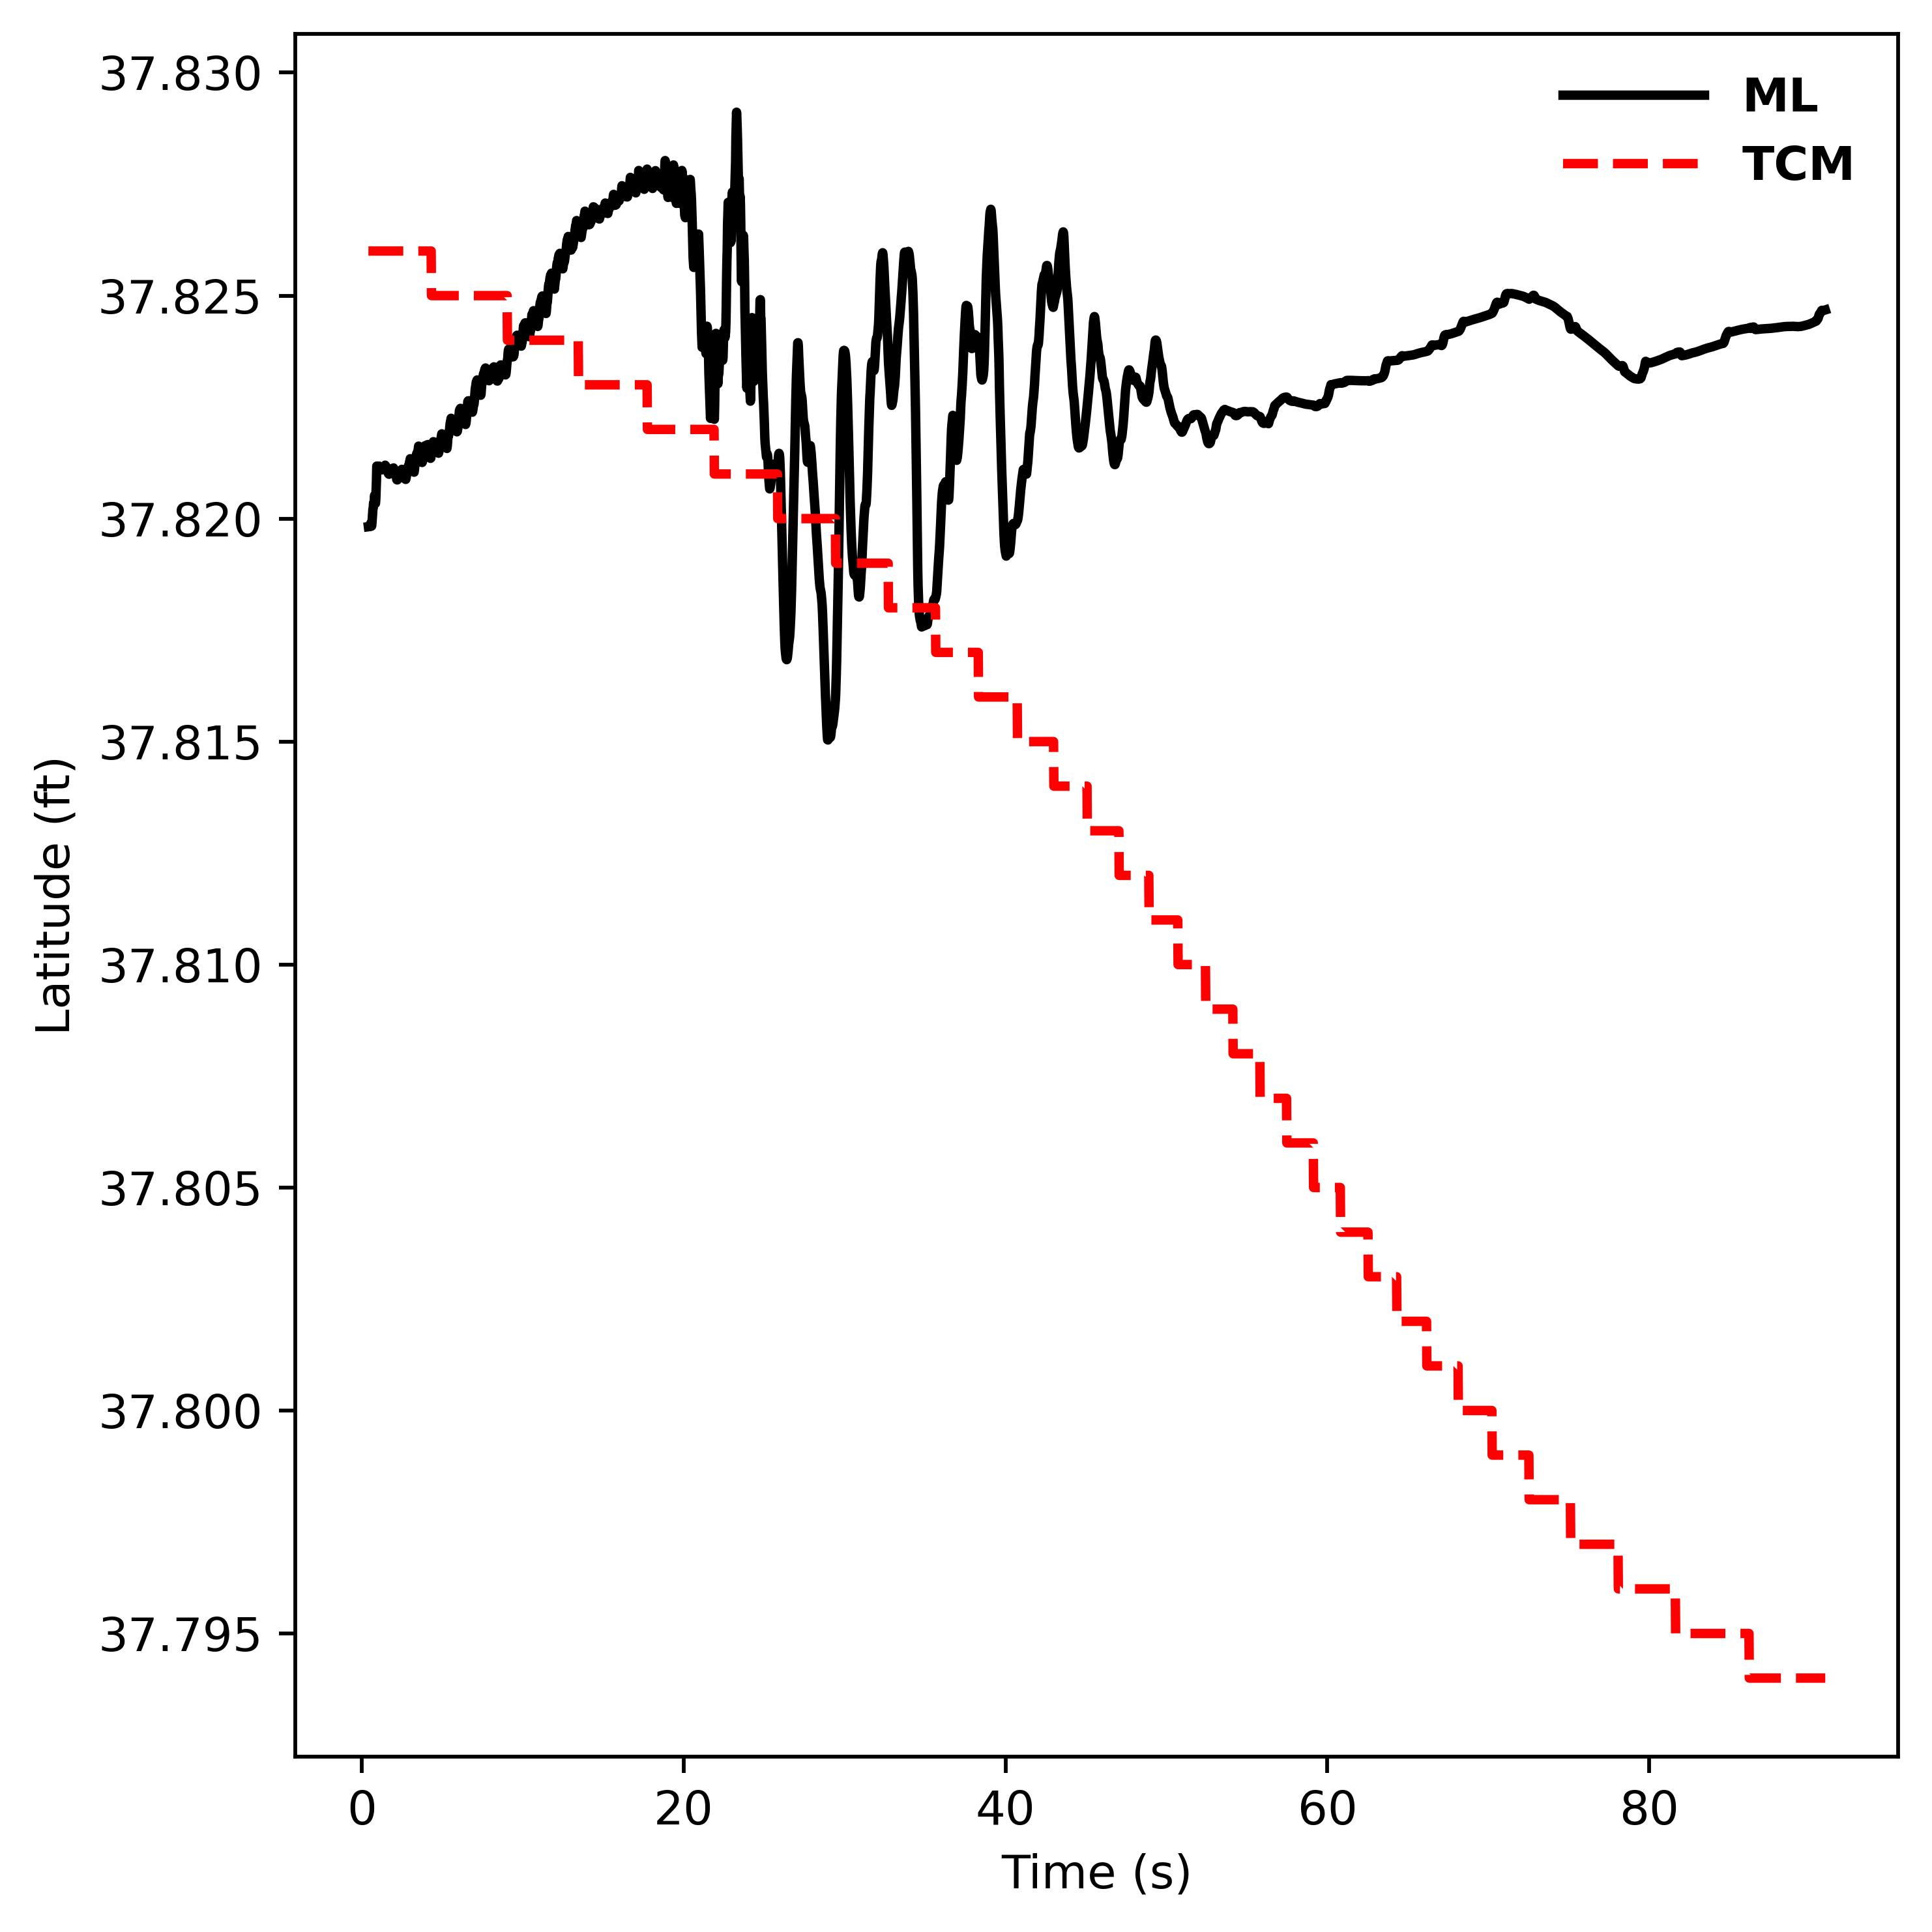

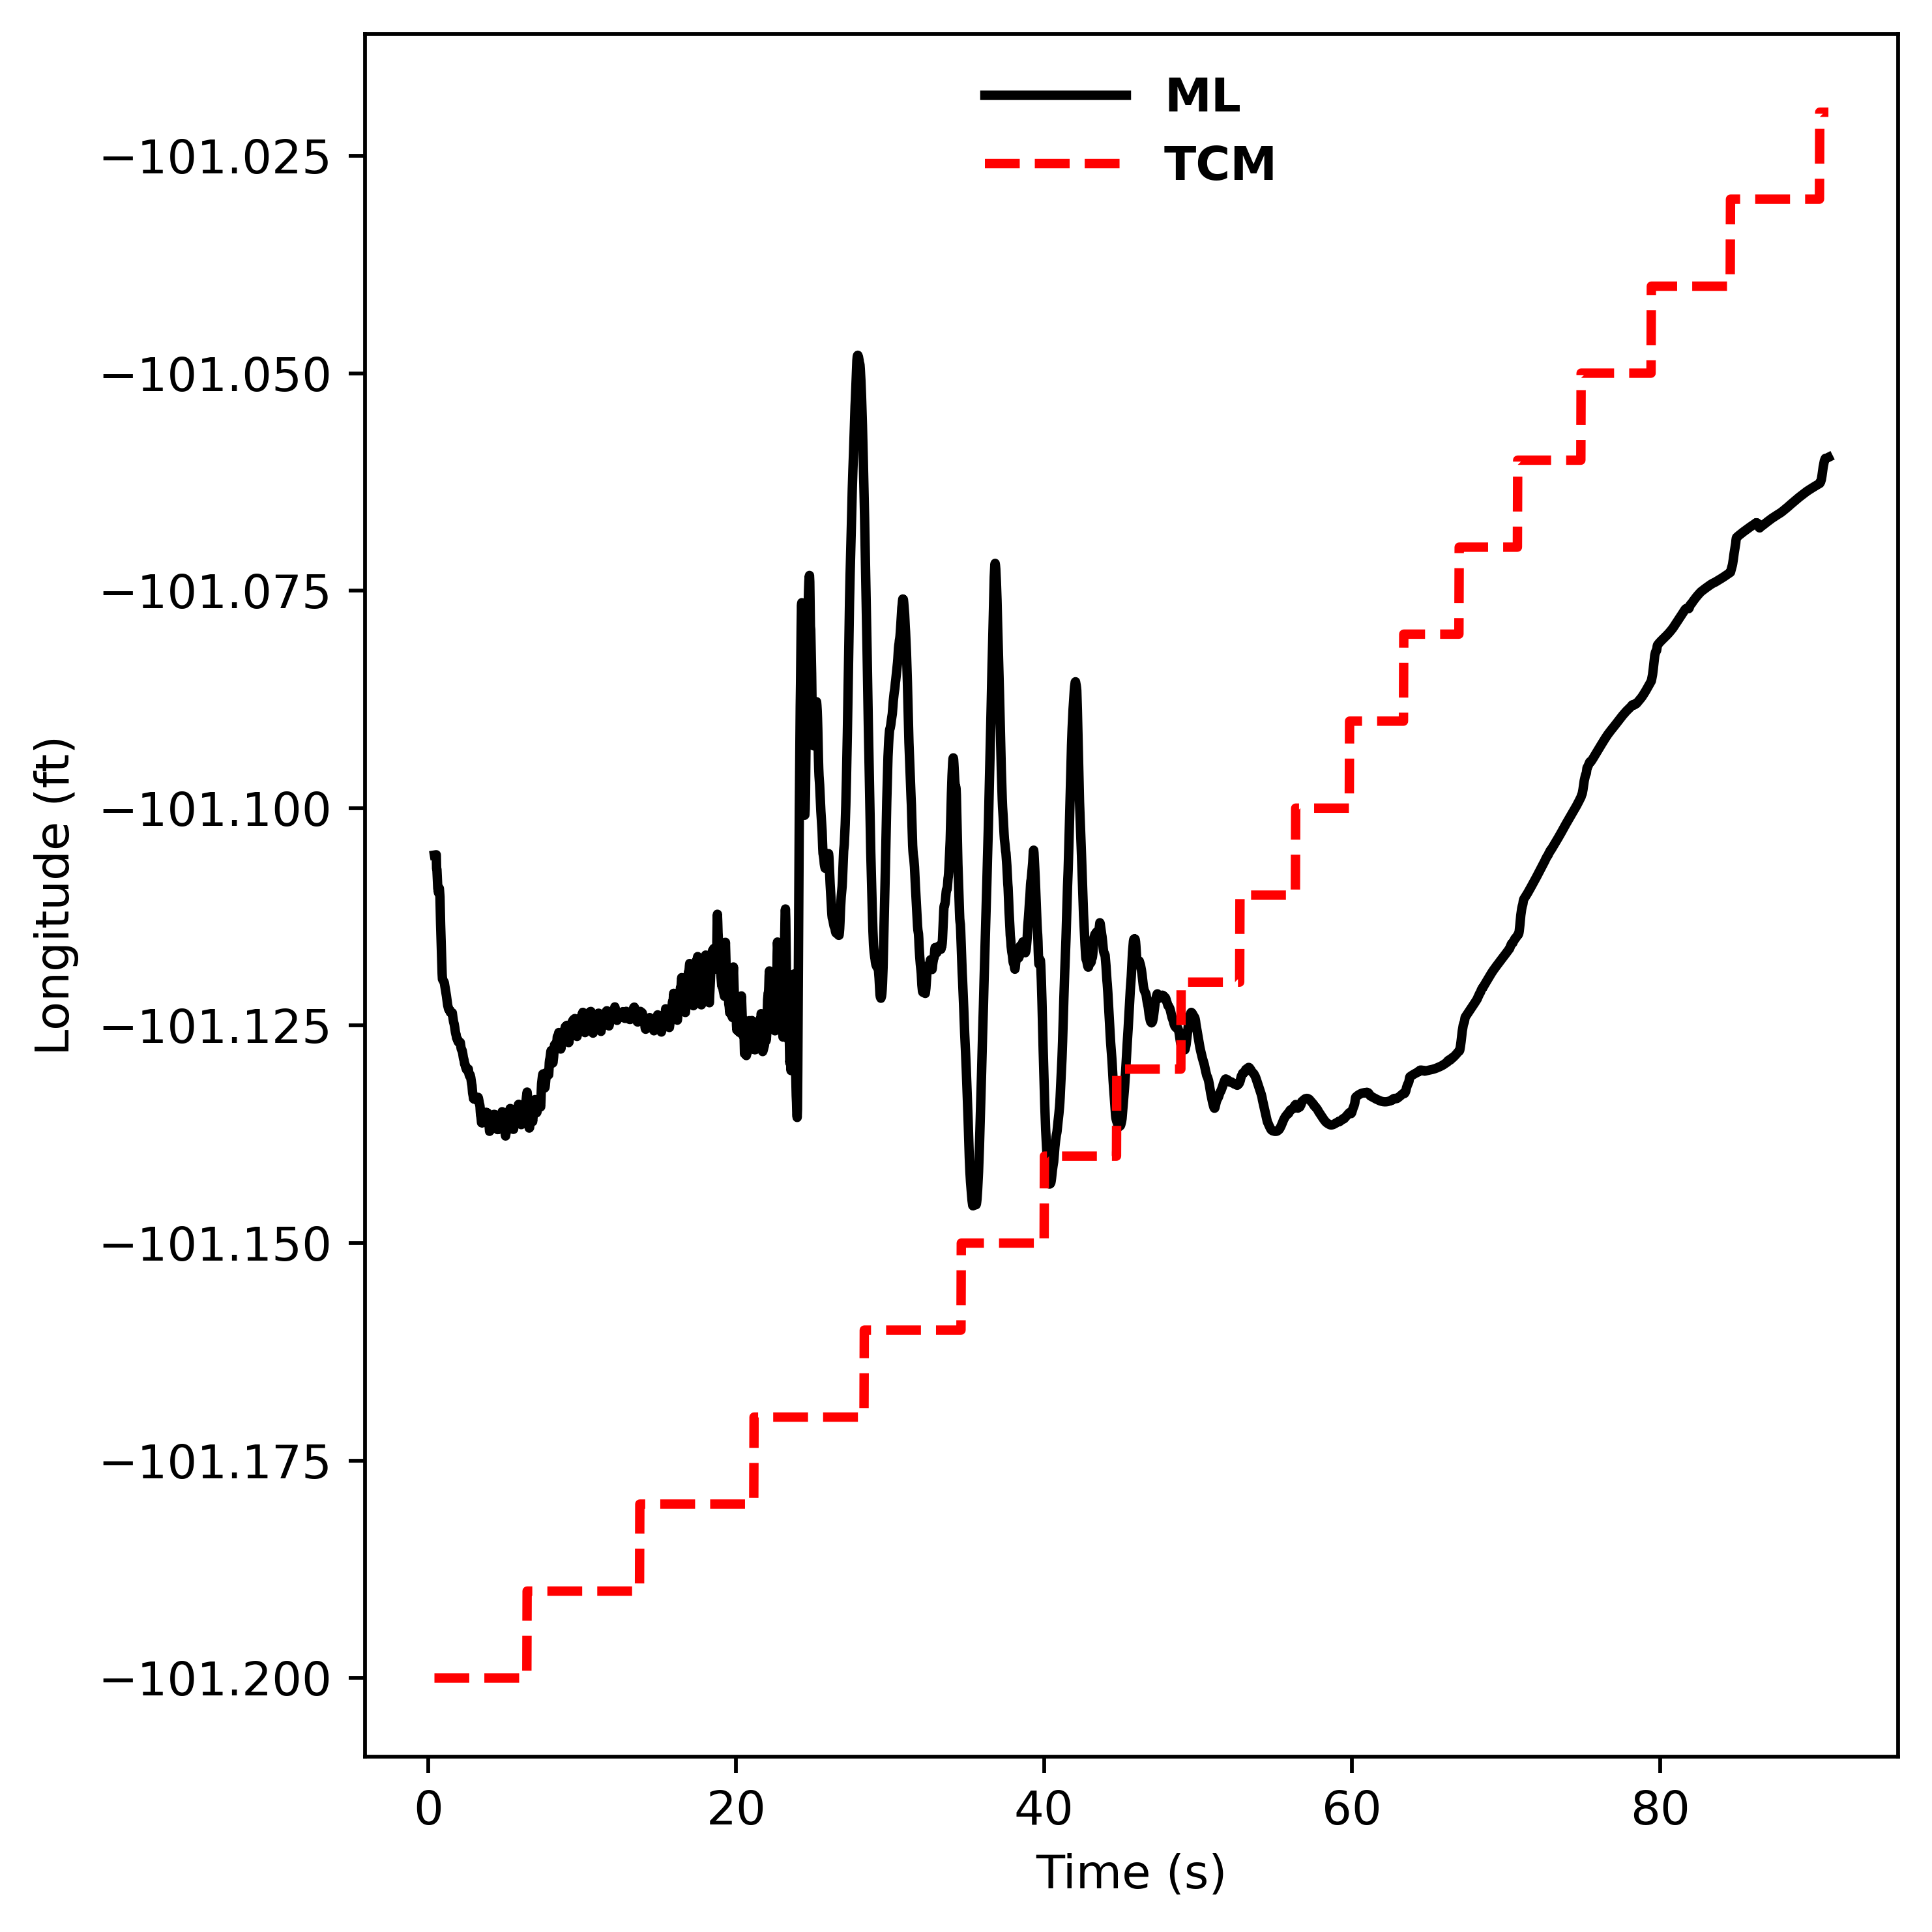

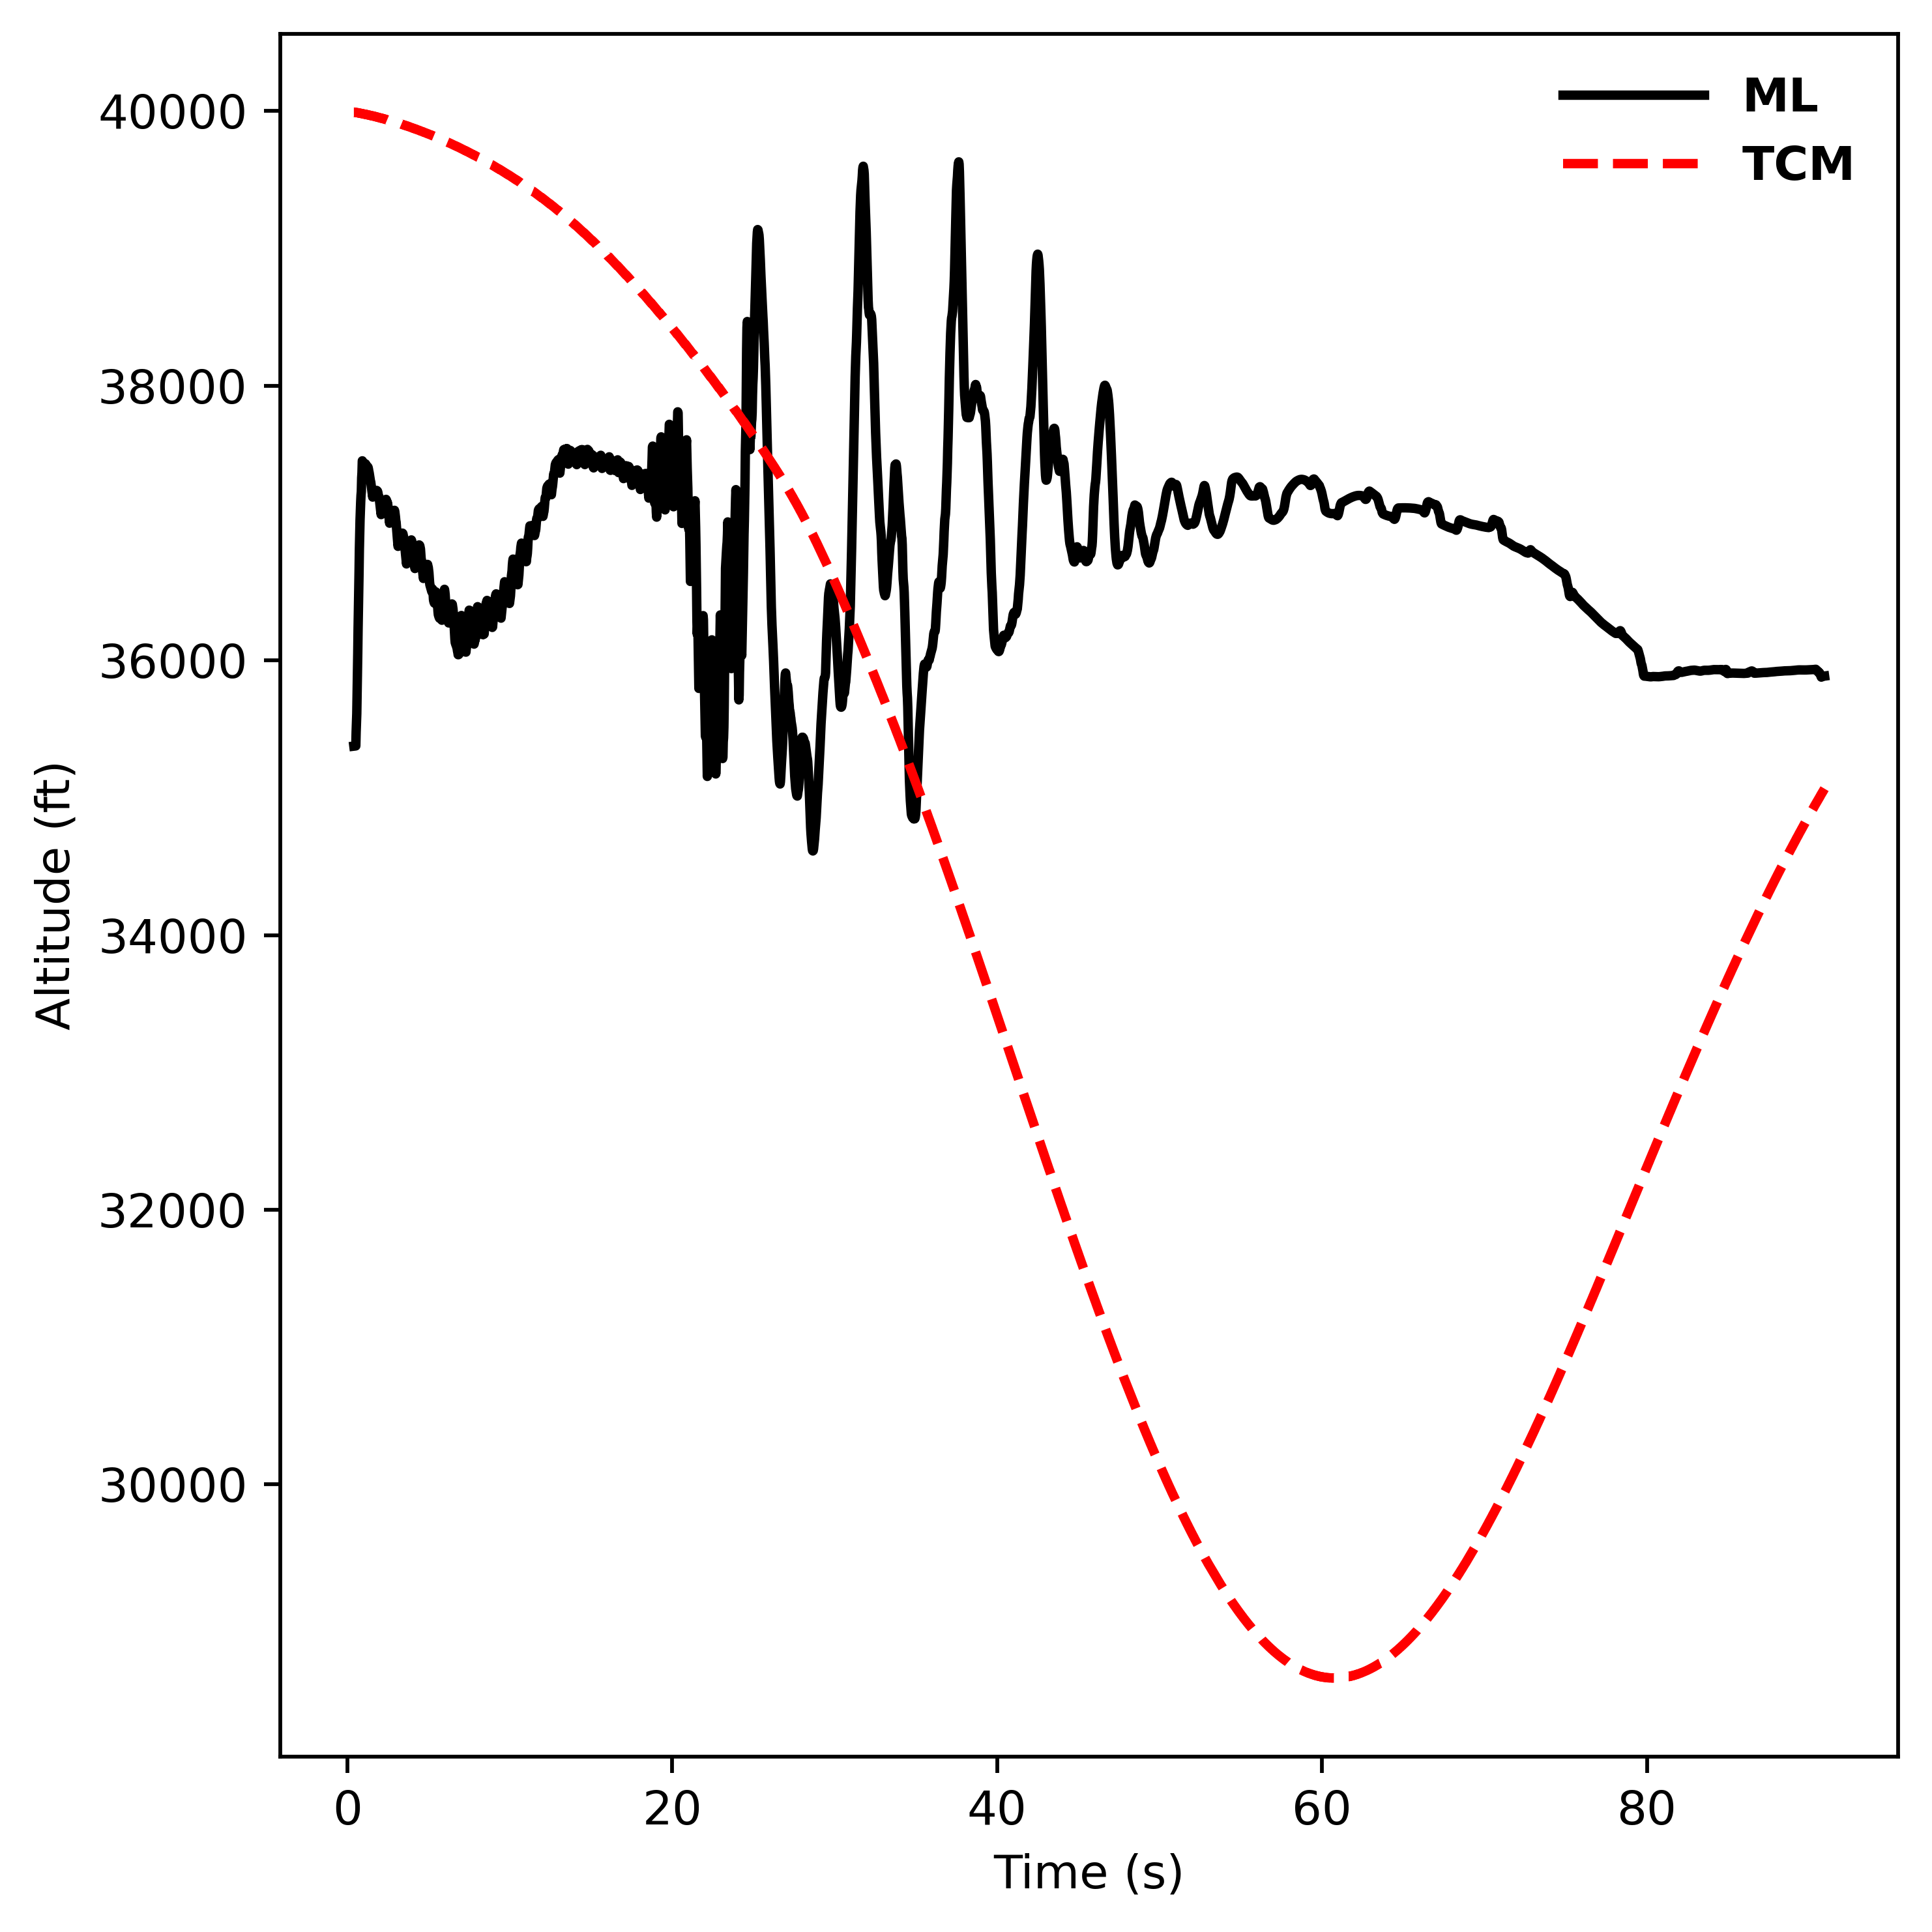

In [99]:
plotResponse(predictedData,orignalData,scaled_Data.shape[0],InitialT,TotalTime,window_size,gtm_dt,outDir)